In [ ]:
!pip install keras-tuner # Install the missing keras-tuner module


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/sample_train.csv')

# Display the first few rows
print(df.head())


   custID  gender  state  cardholder  balance  numTrans  numIntlTrans  \
0       1       1     35           1     3000         4            14   
1       2       2      2           1        0         9             0   
2       3       2      2           1        0        27             9   
3       4       1     15           1        0        12             0   
4       5       1     46           1        0        11            16   

   creditLine  fraudRisk  
0           2          0  
1          18          0  
2          16          0  
3           5          0  
4           7          0  


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner import HyperModel

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy'])

        return model


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'Class' is the target variable and the rest are features
X = df.drop('fraudRisk', axis=1)
y = df['fraudRisk']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from keras_tuner.tuners import RandomSearch

# Initialize the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='fraud_detection')


In [ ]:
# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


Trial 10 Complete [00h 00m 32s]
val_accuracy: 0.9384309649467468

Best val_accuracy So Far: 0.9491062462329865
Total elapsed time: 00h 05m 46s
Best Hyperparameters: {'units_1': 224, 'dropout_1': 0.1, 'units_2': 448, 'dropout_2': 0.0, 'learning_rate': 0.01}


In [ ]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")


Epoch 1/10
252/252 [==============================] - 3s 9ms/step - loss: 37.3172 - accuracy: 0.8869 - val_loss: 0.2835 - val_accuracy: 0.9384
Epoch 2/10
252/252 [==============================] - 3s 10ms/step - loss: 0.3353 - accuracy: 0.9379 - val_loss: 0.2240 - val_accuracy: 0.9394
Epoch 3/10
252/252 [==============================] - 2s 8ms/step - loss: 0.2049 - accuracy: 0.9415 - val_loss: 0.2103 - val_accuracy: 0.9384
Epoch 4/10
252/252 [==============================] - 1s 5ms/step - loss: 0.2112 - accuracy: 0.9398 - val_loss: 0.2127 - val_accuracy: 0.9384
Epoch 5/10
252/252 [==============================] - 1s 5ms/step - loss: 0.2356 - accuracy: 0.9395 - val_loss: 0.2198 - val_accuracy: 0.9384
Epoch 6/10
252/252 [==============================] - 1s 5ms/step - loss: 0.2131 - accuracy: 0.9392 - val_loss: 0.2105 - val_accuracy: 0.9384
Epoch 7/10
252/252 [==============================] - 1s 5ms/step - loss: 0.2077 - accuracy: 0.9395 - val_loss: 0.2153 - val_accuracy: 0.9369
Epoc

In [ ]:
# Retrain the model on the entire dataset with the best hyperparameters (optional)
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(X, y, epochs=10)


Epoch 1/10
315/315 [==============================] - 2s 5ms/step - loss: 24.6110 - accuracy: 0.8824
Epoch 2/10
315/315 [==============================] - 1s 5ms/step - loss: 0.2887 - accuracy: 0.9297
Epoch 3/10
315/315 [==============================] - 3s 10ms/step - loss: 0.2440 - accuracy: 0.9363
Epoch 4/10
315/315 [==============================] - 3s 9ms/step - loss: 0.2107 - accuracy: 0.9399
Epoch 5/10
315/315 [==============================] - 2s 8ms/step - loss: 0.2819 - accuracy: 0.9368
Epoch 6/10
315/315 [==============================] - 1s 5ms/step - loss: 0.1964 - accuracy: 0.9407
Epoch 7/10
315/315 [==============================] - 1s 5ms/step - loss: 0.1738 - accuracy: 0.9414
Epoch 8/10
315/315 [==============================] - 1s 5ms/step - loss: 0.1666 - accuracy: 0.9423
Epoch 9/10
315/315 [==============================] - 2s 5ms/step - loss: 0.1783 - accuracy: 0.9438
Epoch 10/10
315/315 [==============================] - 2s 5ms/step - loss: 0.1652 - accuracy: 0.94

Epoch 1/10
252/252 [==============================] - 3s 11ms/step - loss: 0.2110 - accuracy: 0.9397 - val_loss: 0.2065 - val_accuracy: 0.9384
Epoch 2/10
252/252 [==============================] - 5s 19ms/step - loss: 0.2558 - accuracy: 0.9397 - val_loss: 0.2158 - val_accuracy: 0.9384
Epoch 3/10
252/252 [==============================] - 3s 13ms/step - loss: 0.2221 - accuracy: 0.9399 - val_loss: 0.2308 - val_accuracy: 0.9384
Epoch 4/10
252/252 [==============================] - 2s 8ms/step - loss: 0.2197 - accuracy: 0.9399 - val_loss: 0.2316 - val_accuracy: 0.9384
Epoch 5/10
252/252 [==============================] - 2s 6ms/step - loss: 0.2282 - accuracy: 0.9398 - val_loss: 0.2314 - val_accuracy: 0.9384
Epoch 6/10
252/252 [==============================] - 1s 6ms/step - loss: 0.2303 - accuracy: 0.9398 - val_loss: 0.2324 - val_accuracy: 0.9384
Epoch 7/10
252/252 [==============================] - 1s 5ms/step - loss: 0.2363 - accuracy: 0.9397 - val_loss: 0.2312 - val_accuracy: 0.9384
Epo

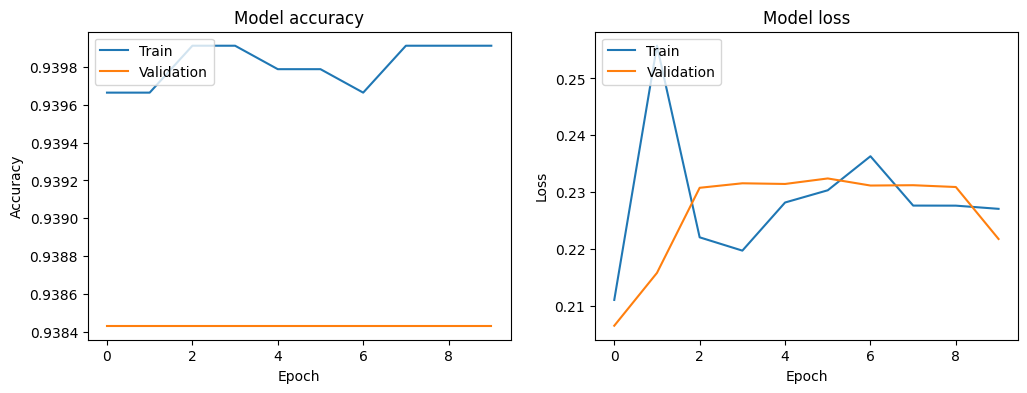

In [ ]:
import matplotlib.pyplot as plt

# Assume `history` is the object returned by model.fit()
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


63/63 [==============================] - 1s 10ms/step


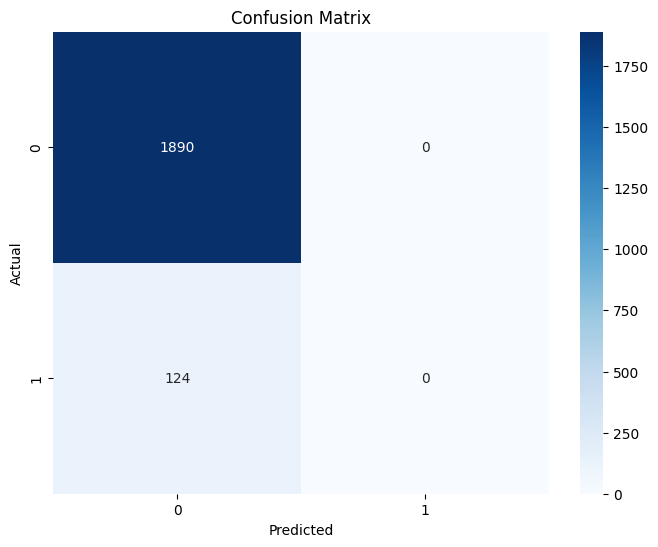

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the validation set
y_pred = best_model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


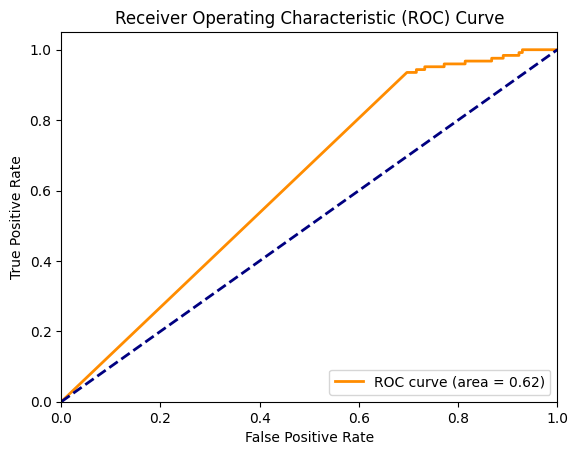

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv('/content/sample_train.csv')

# Display the first few rows
print(df.head())

# Handle categorical variables
# Encode 'gender' and 'state' as they are categorical
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['state'] = label_encoder.fit_transform(df['state'])

# Separate features and target variable
X = df.drop(['custID', 'fraudRisk'], axis=1)  # Exclude 'custID' as it's not a predictive feature
y = df['fraudRisk']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


   custID  gender  state  cardholder  balance  numTrans  numIntlTrans  \
0       1       1     35           1     3000         4            14   
1       2       2      2           1        0         9             0   
2       3       2      2           1        0        27             9   
3       4       1     15           1        0        12             0   
4       5       1     46           1        0        11            16   

   creditLine  fraudRisk  
0           2          0  
1          18          0  
2          16          0  
3           5          0  
4           7          0  


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the neural network model
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)


Epoch 1/50
252/252 [==============================] - 3s 5ms/step - loss: 0.2108 - accuracy: 0.9289 - val_loss: 0.1273 - val_accuracy: 0.9563
Epoch 2/50
252/252 [==============================] - 1s 5ms/step - loss: 0.1315 - accuracy: 0.9486 - val_loss: 0.1212 - val_accuracy: 0.9573
Epoch 3/50
252/252 [==============================] - 2s 7ms/step - loss: 0.1203 - accuracy: 0.9510 - val_loss: 0.1232 - val_accuracy: 0.9563
Epoch 4/50
252/252 [==============================] - 1s 3ms/step - loss: 0.1210 - accuracy: 0.9512 - val_loss: 0.1184 - val_accuracy: 0.9588
Epoch 5/50
252/252 [==============================] - 1s 3ms/step - loss: 0.1186 - accuracy: 0.9541 - val_loss: 0.1166 - val_accuracy: 0.9553
Epoch 6/50
252/252 [==============================] - 1s 3ms/step - loss: 0.1183 - accuracy: 0.9539 - val_loss: 0.1166 - val_accuracy: 0.9553
Epoch 7/50
252/252 [==============================] - 1s 3ms/step - loss: 0.1150 - accuracy: 0.9572 - val_loss: 0.1163 - val_accuracy: 0.9563
Epoch 

63/63 [==============================] - 0s 5ms/step - loss: 0.1199 - accuracy: 0.9553
Validation Accuracy: 0.9553127884864807


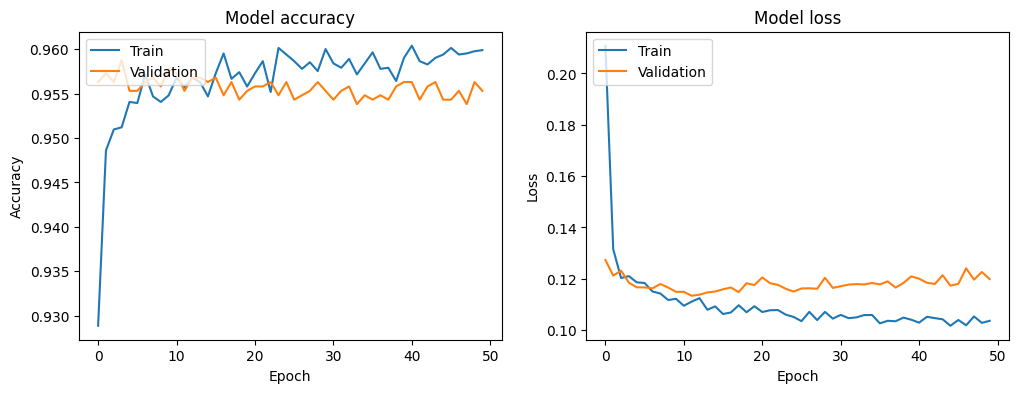

63/63 [==============================] - 1s 5ms/step


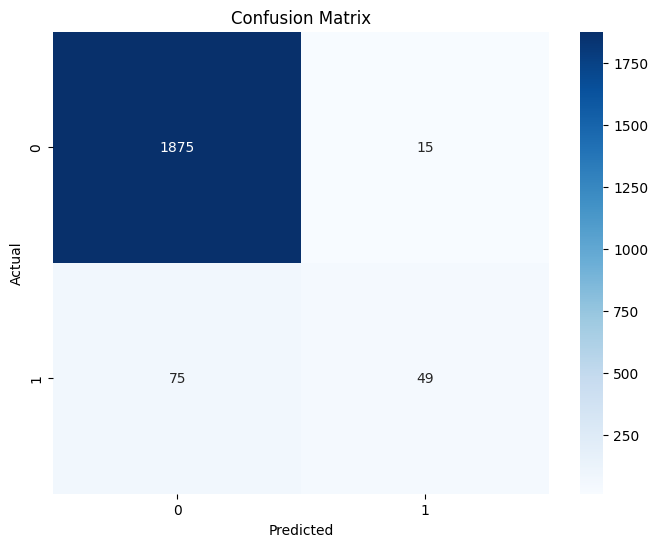

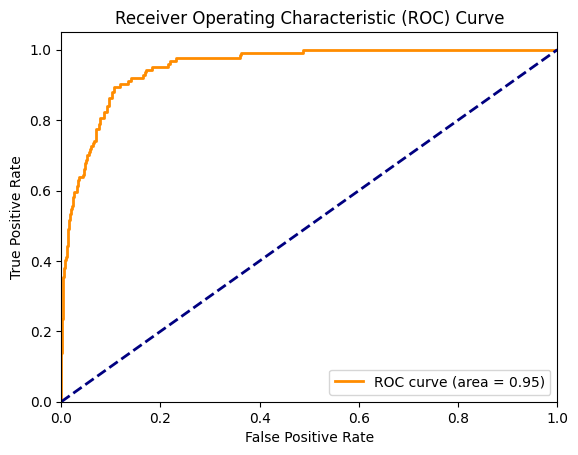

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
df = pd.read_csv('/content/sample_train.csv')

# Data Preprocessing
# Encode categorical variables
label_encoders = {}
for column in ['gender', 'state', 'cardholder']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Split the dataset
X = df.drop(['custID', 'fraudRisk'], axis=1)
y = df['fraudRisk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitness function for feature selection
def feature_selection_fitness(solution):
    selected_features = [feature for feature, select in zip(X_train.columns, solution) if select == 1]
    if len(selected_features) == 0:
        return 0
    X_train_selected = X_train[selected_features]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_train_selected, y_train, cv=5)
    return np.mean(scores)

# Initialize SSA parameters
population_size = 50
max_iterations = 100

# Initialize population
population = np.random.randint(2, size=(population_size, X_train.shape[1]))
best_solution = None
best_fitness = -np.inf

# SSA loop for feature selection
for iteration in range(max_iterations):
    for i in range(population_size):
        if i == 0:
            # Update leader salp
            leader = population[0]
            fitness = feature_selection_fitness(leader)
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = leader
        else:
            # Update follower salps
            follower = population[i]
            new_position = (population[i-1] + follower) / 2
            population[i] = np.round(new_position).astype(int)

    # Update positions
    population[0] = best_solution

# Best features
selected_features = [feature for feature, select in zip(X_train.columns, best_solution) if select == 1]
print("Selected Features: ", selected_features)

# Hyperparameter Optimization using SSA
def hyperparameter_fitness(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    scores = cross_val_score(model, X_train[selected_features], y_train, cv=5)
    return np.mean(scores)

# Initialize hyperparameter search space
param_space = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40]
}

# Initialize SSA parameters for hyperparameter optimization
population_size = 20
max_iterations = 50

# Initialize population
population = np.random.randint(2, size=(population_size, len(param_space)))
best_solution = None
best_fitness = -np.inf

# SSA loop for hyperparameter optimization
for iteration in range(max_iterations):
    for i in range(population_size):
        if i == 0:
            # Update leader salp
            leader = population[0]
            params = [param_space[key][value] for key, value in zip(param_space.keys(), leader)]
            fitness = hyperparameter_fitness(params)
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = leader
        else:
            # Update follower salps
            follower = population[i]
            new_position = (population[i-1] + follower) / 2
            population[i] = np.round(new_position).astype(int)

    # Update positions
    population[0] = best_solution

# Best hyperparameters
best_params = [param_space[key][value] for key, value in zip(param_space.keys(), best_solution)]
print("Best Hyperparameters: ", best_params)

# Train final model with best features and hyperparameters
model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], random_state=42)
model.fit(X_train[selected_features], y_train)
accuracy = model.score(X_test[selected_features], y_test)
print("Final Model Accuracy: ", accuracy)


Selected Features:  ['balance', 'numIntlTrans', 'creditLine']


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [ ]:
pip install numpy pandas scikit-learn pySwarms tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 945.7 kB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('/content/sample_train.csv')

# Preprocess your data
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split data into features and target
X = data.drop('fraudRisk', axis=1)
y = data['fraudRisk']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the fitness function
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def fitness_function(particle):
    # No need to flatten the particle, keep it as a 2D array
    mask = (particle > 0.5)

    if np.sum(mask) == 0:
        return 1.0  # If no features are selected, return worst fitness

    X_selected = X_train[:, mask[0]] # Use mask[0] to index along the correct dimension
    model = create_model(X_selected.shape[1])
    model.fit(X_selected, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_selected, y_train, verbose=0)
    return 1.0 - accuracy  # We minimize the fitness, so return 1 - accuracy

In [ ]:
import pyswarms as ps

# Initialize swarm size and dimensions
n_particles = 30
dimensions = X_train.shape[1]

# Set boundaries for each particle
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)

# Perform optimization
best_cost, best_pos = optimizer.optimize(fitness_function, iters=100)

# Get the best features
best_features = np.where(best_pos > 0.5)[0]
print("Selected features:", best_features)
import pyswarms as ps

# Initialize swarm size and dimensions
n_particles = 30
dimensions = X_train.shape[1]

# Set boundaries for each particle
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)

# Perform optimization
best_cost, best_pos = optimizer.optimize(fitness_function, iters=100)

# Get the best features
best_features = np.where(best_pos > 0.5)[0]
print("Selected features:", best_features)


2024-06-24 05:48:26,519 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0393
2024-06-24 05:58:20,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.039301931858062744, best pos: [1.36805696 0.2990935  1.01183169 1.47671394 2.02322818 2.47509323
 1.87252634 1.01020259]
2024-06-24 05:58:20,513 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Selected features: [0 2 3 4 5 6 7]


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0372
2024-06-24 06:08:42,613 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.037173688411712646, best pos: [0.93037521 1.41195767 0.87537689 1.67244426 1.80548783 0.93603023
 1.17330089 1.59250354]


Selected features: [0 1 2 3 4 5 6 7]


In [ ]:
# Get the best features
best_features = np.where(best_pos > 1.5)[0]
print("Selected features:", best_features)

Selected features: [3 4 7]


In [ ]:
# Extract selected features
selected_features = [3, 4, 7]  # Based on the first run

# Train the deep learning model on the selected features
X_selected_train = X_train[:, selected_features]
X_selected_test = X_test[:, selected_features]

model = create_model(X_selected_train.shape[1])
model.fit(X_selected_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_selected_test, y_test, verbose=0)
print("Accuracy with selected features:", accuracy)


Epoch 1/50
221/221 [==============================] - 2s 4ms/step - loss: 0.2558 - accuracy: 0.9377
Epoch 2/50
221/221 [==============================] - 1s 4ms/step - loss: 0.1443 - accuracy: 0.9491
Epoch 3/50
221/221 [==============================] - 1s 3ms/step - loss: 0.1421 - accuracy: 0.9489
Epoch 4/50
221/221 [==============================] - 0s 2ms/step - loss: 0.1416 - accuracy: 0.9496
Epoch 5/50
221/221 [==============================] - 0s 2ms/step - loss: 0.1414 - accuracy: 0.9508
Epoch 6/50
221/221 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.9489
Epoch 7/50
221/221 [==============================] - 0s 2ms/step - loss: 0.1419 - accuracy: 0.9484
Epoch 8/50
221/221 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9506
Epoch 9/50
221/221 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9495
Epoch 10/50
221/221 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.9488

In [ ]:
##################################################

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('/content/sample_train_1.csv')  # Replace 'your_dataset.csv' with the actual file path

# Split data into features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the fitness function
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def fitness_function(particle):
    mask = particle > 0.5
    if np.sum(mask) == 0:
        return 1.0  # If no features are selected, return worst fitness

    selected_indices = np.where(mask)[0]  # Get the indices of selected features
    X_selected = X_train[:, selected_indices]  # Select columns based on the indices
    model = create_model(X_selected.shape[1])
    model.fit(X_selected, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_selected, y_train, verbose=0)
    return 1.0 - accuracy  # We minimize the fitness, so return 1 - accuracy


In [ ]:
import pyswarms as ps

# Initialize swarm size and dimensions
n_particles = 30
dimensions = X_train.shape[1]

# Set boundaries for each particle
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)

# Perform optimization
best_cost, best_pos = optimizer.optimize(fitness_function, iters=100)

# Get the best features
best_features = np.where(best_pos > 0.5)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)


2024-06-24 06:46:22,554 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0
2024-06-24 06:57:51,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.38999563 0.86966647 0.86902039 0.37665729 0.3112507  0.89598125
 0.49604805 0.83771236 0.83578895 0.08965062 0.32852244 0.64757062
 0.78211552 0.55011574 0.26795252 0.82184897 0.83942457 0.23581149
 0.33524915 0.23356635 0.38015433 0.72099616 0.54478187 0.50400861
 0.91521152 0.91927053 0.85765683 0.07731831 0.09020234 0.9322827 ]


Selected features: Index(['V1', 'V2', 'V5', 'V7', 'V8', 'V11', 'V12', 'V13', 'V15', 'V16', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'Amount'],
      dtype='object')


In [ ]:
# Extract selected features
X_selected_train = X_train[:, best_features]
X_selected_test = X_test[:, best_features]

# Train the deep learning model on the selected features
model = create_model(X_selected_train.shape[1])
model.fit(X_selected_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_selected_test, y_test, verbose=0)
print("Accuracy with selected features:", accuracy)


Epoch 1/50
228/228 [==============================] - 1s 2ms/step - loss: 0.0956 - accuracy: 0.9824
Epoch 2/50
228/228 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 0.9989
Epoch 3/50
228/228 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 0.9996
Epoch 4/50
228/228 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9999
Epoch 5/50
228/228 [==============================] - 0s 2ms/step - loss: 6.5531e-04 - accuracy: 0.9999
Epoch 6/50
228/228 [==============================] - 0s 2ms/step - loss: 4.0926e-04 - accuracy: 1.0000
Epoch 7/50
228/228 [==============================] - 0s 2ms/step - loss: 2.9898e-04 - accuracy: 1.0000
Epoch 8/50
228/228 [==============================] - 0s 2ms/step - loss: 2.0307e-04 - accuracy: 1.0000
Epoch 9/50
228/228 [==============================] - 0s 2ms/step - loss: 1.4726e-04 - accuracy: 1.0000
Epoch 10/50
228/228 [==============================] - 0s 2ms/step - loss: 1.134

In [ ]:
################################################################

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('/content/sample_train_2.csv')  # Replace 'your_dataset.csv' with the actual file path

# Split data into features and target
X = data.drop('default payment next month', axis=1)
y = data['default payment next month']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the fitness function
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def fitness_function(particle):
    mask = particle > 0.5
    if np.sum(mask) == 0:
        return 1.0  # If no features are selected, return worst fitness

    selected_indices = np.where(mask)[0]  # Get the indices of selected features
    # Ensure selected indices are within the valid range
    selected_indices = [i for i in selected_indices if i < X_train.shape[1]]
    if not selected_indices: # Handle the case where no valid indices are left
        return 1.0
    X_selected = X_train[:, selected_indices]  # Select columns based on the indices
    model = create_model(X_selected.shape[1])
    model.fit(X_selected, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_selected, y_train, verbose=0)
    return 1.0 - accuracy  # We minimize the fitness, so return 1 - accuracy

In [ ]:
import pyswarms as ps

# Initialize swarm size and dimensions
n_particles = 30
dimensions = X_train.shape[1]

# Set boundaries for each particle
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)

# Perform optimization
best_cost, best_pos = optimizer.optimize(fitness_function, iters=100)

# Get the best features
best_features = np.where(best_pos > 1.5)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)


2024-06-24 09:38:27,250 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.166
2024-06-24 09:50:25,163 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16570007801055908, best pos: [1.21851269 2.07446525 1.20449114 1.07063679 1.83538902 1.24923948
 1.48412319 0.411809   1.31161258 1.41107942 1.65698303 1.5576832
 1.22954773 2.49671933 0.66721793 1.52351174 0.96919658 1.05624648
 1.80191989 2.10177469 0.8408163  0.58125771 2.70185354 1.44697348]


Selected features: Index(['LIMIT_BAL', 'MARRIAGE', 'PAY_5', 'PAY_6', 'BILL_AMT2', 'BILL_AMT4',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT5'],
      dtype='object')


In [ ]:
# Extract selected features
X_selected_train = X_train[:, best_features]
X_selected_test = X_test[:, best_features]

# Train the deep learning model on the selected features
model = create_model(X_selected_train.shape[1])
model.fit(X_selected_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_selected_test, y_test, verbose=0)
print("Accuracy with selected features:", accuracy)


Epoch 1/50
227/227 [==============================] - 1s 2ms/step - loss: 0.5177 - accuracy: 0.7829
Epoch 2/50
227/227 [==============================] - 0s 2ms/step - loss: 0.4818 - accuracy: 0.8009
Epoch 3/50
227/227 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.8014
Epoch 4/50
227/227 [==============================] - 1s 3ms/step - loss: 0.4764 - accuracy: 0.7995
Epoch 5/50
227/227 [==============================] - 1s 3ms/step - loss: 0.4754 - accuracy: 0.8013
Epoch 6/50
227/227 [==============================] - 1s 5ms/step - loss: 0.4745 - accuracy: 0.8019
Epoch 7/50
227/227 [==============================] - 1s 6ms/step - loss: 0.4726 - accuracy: 0.7999
Epoch 8/50
227/227 [==============================] - 1s 6ms/step - loss: 0.4716 - accuracy: 0.8012
Epoch 9/50
227/227 [==============================] - 1s 6ms/step - loss: 0.4720 - accuracy: 0.8009
Epoch 10/50
227/227 [==============================] - 1s 3ms/step - loss: 0.4716 - accuracy: 0.8017

In [ ]:
#################################################################################################

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset, trying different encodings
try:
    data = pd.read_csv('/content/sample_train_3.csv', encoding='latin-1')  # Try 'latin-1' first
except UnicodeDecodeError:
    data = pd.read_csv('/content/sample_train_3.csv', encoding='utf-16')  # Try 'utf-16' if 'latin-1' fails

# Split data into features and target
X = data.drop('pais_estabelecimento', axis=1)
y = data['pais_estabelecimento']

# Identify and handle non-numeric columns
numeric_cols = X.select_dtypes(include=['float', 'int']).columns
X_numeric = X[numeric_cols]  # Select only numeric columns for scaling

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42)

# Normalize the numerical data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the fitness function
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def fitness_function(particle):
    mask = particle > 0.5
    if np.sum(mask) == 0:
        return 1.0  # If no features are selected, return worst fitness

    selected_indices = np.where(mask)[0]  # Get the indices of selected features
    # Ensure selected indices are within the valid range
    selected_indices = [i for i in selected_indices if i < X_train.shape[1]]
    if not selected_indices: # Handle the case where no valid indices are left
        return 1.0
    X_selected = X_train[:, selected_indices]  # Select columns based on the indices
    model = create_model(X_selected.shape[1])
    # Convert y_train to numerical labels if they are strings
    if y_train.dtype == 'object':
        unique_labels = y_train.unique()
        label_mapping = {label: i for i, label in enumerate(unique_labels)}
        y_train_numerical = y_train.map(label_mapping)
    else:
        y_train_numerical = y_train

    # Convert numerical labels to binary values (0 or 1) if needed
    y_train_binary = (y_train_numerical > 0).astype(int)  # Assuming positive values map to 1, others to 0
    model.fit(X_selected, y_train_binary, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_selected, y_train_binary, verbose=0)
    return 1.0 - accuracy  # We minimize the fitness, so return 1 - accuracy

In [ ]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.2 MB/s eta 0:00:00


In [ ]:
import pyswarms as ps

# Initialize swarm size and dimensions
n_particles = 30
dimensions = X_train.shape[1]

# Set boundaries for each particle
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)

# Perform optimization
best_cost, best_pos = optimizer.optimize(fitness_function, iters=100)

# Get the best features
best_features = np.where(best_pos > 0.5)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)


2024-06-24 18:27:39,887 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.241
2024-06-24 18:31:35,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.24060148000717163, best pos: [0.80672309 0.87711499 0.0667902  0.77608698 0.60742367 1.29367825]


Selected features: Index([], dtype='object')


In [ ]:
best_features = np.where(best_pos > 0.5)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)

Selected features: Index(['id', 'safra_abertura', 'cidade', 'estado', 'idade'], dtype='object')


In [ ]:
# Extract selected features
X_selected_train = X_train[:, best_features]
X_selected_test = X_test[:, best_features]

# Train the deep learning model on the selected features
model = create_model(X_selected_train.shape[1])

# Convert y_train to numerical labels if they are not already
if y_train.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test) # Assuming y_test has the same labels

model.fit(X_selected_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_selected_test, y_test, verbose=0)
print("Accuracy with selected features:", accuracy)

Epoch 1/50
38/38 [==============================] - 2s 7ms/step - loss: 0.6238 - accuracy: 0.7218
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.5570 - accuracy: 0.7569
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.5456 - accuracy: 0.7569
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.5396 - accuracy: 0.7569
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.5371 - accuracy: 0.7569
Epoch 6/50
38/38 [==============================] - 0s 6ms/step - loss: 0.5348 - accuracy: 0.7569
Epoch 7/50
38/38 [==============================] - 0s 4ms/step - loss: 0.5338 - accuracy: 0.7569
Epoch 8/50
38/38 [==============================] - 0s 5ms/step - loss: 0.5319 - accuracy: 0.7569
Epoch 9/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5305 - accuracy: 0.7586
Epoch 10/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5301 - accuracy: 0.7569
Epoch 11/50
38/38 [

In [ ]:
############################################################

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('/content/sample_train_4.csv')  # Replace 'your_dataset.csv' with the actual file path

# Split data into features and target
X = data.drop('fraud', axis=1)
y = data['fraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the fitness function
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def fitness_function(particle):
    # Ensure particles are within bounds [0, dimensions-1] and are integers
    rounded_particle = np.round(particle).astype(int)
    mask = rounded_particle > 0.5
    if np.sum(mask) == 0:
        return 1.0  # If no features are selected, return worst fitness

    selected_indices = np.where(mask)[0]
    # Ensure indices are within the valid range
    valid_indices = np.clip(selected_indices, 0, X_train.shape[1]-1)
    X_selected = X_train[:, valid_indices]
    model = create_model(X_selected.shape[1])
    model.fit(X_selected, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_selected, y_train, verbose=0)
    return 1.0 - accuracy  # We minimize the fitness, so return 1 - accuracy

In [ ]:
import pyswarms as ps

# Initialize swarm size and dimensions
n_particles = 30
dimensions = X_train.shape[1]

# Set boundaries for each particle
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)

# Perform optimization
best_cost, best_pos = optimizer.optimize(fitness_function, iters=100)

# Get the best features
best_features = np.where(best_pos > 1)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)


2024-06-24 19:29:01,557 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.00301
2024-06-24 19:41:02,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.003010869026184082, best pos: [0.4840685  0.46550593 0.20807284 0.55593814 1.00287938 0.48579446
 1.10336085]


Selected features: Index(['used_chip', 'online_order'], dtype='object')


In [ ]:
# Get the best features
best_features = np.where(best_pos > 0.5)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)

Selected features: Index(['repeat_retailer', 'used_chip', 'online_order'], dtype='object')


In [ ]:
# Extract selected features
X_selected_train = X_train[:, best_features]
X_selected_test = X_test[:, best_features]

# Train the deep learning model on the selected features
model = create_model(X_selected_train.shape[1])

# Convert y_train to numerical labels if they are not already
if y_train.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test) # Assuming y_test has the same labels

model.fit(X_selected_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_selected_test, y_test, verbose=0)
print("Accuracy with selected features:", accuracy)

Epoch 1/50
239/239 [==============================] - 2s 3ms/step - loss: 0.3087 - accuracy: 0.9059
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: 0.2544 - accuracy: 0.9182
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.2538 - accuracy: 0.9182
Epoch 4/50
239/239 [==============================] - 0s 2ms/step - loss: 0.2532 - accuracy: 0.9182
Epoch 5/50
239/239 [==============================] - 1s 2ms/step - loss: 0.2531 - accuracy: 0.9182
Epoch 6/50
239/239 [==============================] - 0s 2ms/step - loss: 0.2534 - accuracy: 0.9182
Epoch 7/50
239/239 [==============================] - 0s 2ms/step - loss: 0.2536 - accuracy: 0.9182
Epoch 8/50
239/239 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.9182
Epoch 9/50
239/239 [==============================] - 0s 2ms/step - loss: 0.2528 - accuracy: 0.9182
Epoch 10/50
239/239 [==============================] - 1s 2ms/step - loss: 0.2531 - accuracy: 0.9182

In [ ]:
#################################################################################################

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('/content/sample_train_5.csv')  # Replace 'your_dataset.csv' with the actual file path

# Split data into features and target
X = data.drop('TARGET', axis=1)
y = data['TARGET']

# Identify and handle non-numerical columns (e.g., drop or one-hot encode)
# Here, we'll drop non-numerical columns for simplicity
X = X.select_dtypes(include=['number'])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the fitness function
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def fitness_function(particle):
    # Ensure particles are within bounds [0, dimensions-1] and are integers
    rounded_particle = np.round(particle).astype(int)
    mask = rounded_particle > 0.5
    if np.sum(mask) == 0:
        return 1.0  # If no features are selected, return worst fitness

    selected_indices = np.where(mask)[0]
    # Ensure indices are within the valid range
    valid_indices = np.clip(selected_indices, 0, X_train.shape[1]-1)
    X_selected = X_train[:, valid_indices]
    model = create_model(X_selected.shape[1])
    model.fit(X_selected, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_selected, y_train, verbose=0)
    return 1.0 - accuracy  # We minimize the fitness, so return 1 - accuracy

In [ ]:
import pyswarms as ps

# Initialize swarm size and dimensions
n_particles = 30
dimensions = X_train.shape[1]

# Set boundaries for each particle
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize the optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)

# Perform optimization
best_cost, best_pos = optimizer.optimize(fitness_function, iters=100)

# Get the best features
best_features = np.where(best_pos > 1)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)


2024-06-24 19:58:02,391 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0784
2024-06-24 20:19:18,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.07837724685668945, best pos: [0.4775095  0.47240796 0.68452527 0.66460422 0.6912118  0.01675735
 0.62331737 0.41934937 0.96342635 0.68664033 0.56441485 0.59105562
 0.04375422 0.44684592 0.69785804 0.34799746 0.39160622 0.71358627
 0.01367764 0.17602201 0.95772089 0.29402105 0.54511543 0.05388459
 0.1734553  0.2884298  0.09128871 0.89114614 0.72671139 0.02632263
 0.08082345 0.22431113 0.60268113 0.80724749 0.14781175 0.78031431
 0.25207719 0.18021374 0.7569514  0.74557861 0.22146537 0.38065396
 0.59792137 0.88650517 0.54854024 0.98221485 0.39339647 0.4515738
 0.96043139 0.97809512 0.09716708 0.98142493 0.51616897 0.11768953
 0.05741537 0.84526827 0.90839338 0.73883904 0.76481552 0.88678376
 0.3659

Selected features: Index([], dtype='object')


In [ ]:
# Get the best features
best_features = np.where(best_pos > 0.9)[0]

# Map indices to feature names
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print("Selected features:", selected_feature_names)

Selected features: Index(['DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'APARTMENTS_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ENTRANCES_MODE',
       'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'TOTALAREA_MODE',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_WEEK'],
      dtype='object')


In [ ]:
# Extract selected features
X_selected_train = X_train[:, best_features]
X_selected_test = X_test[:, best_features]

# Train the deep learning model on the selected features
model = create_model(X_selected_train.shape[1])

# Convert y_train to numerical labels if they are not already
if y_train.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test) # Assuming y_test has the same labels

model.fit(X_selected_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_selected_test, y_test, verbose=0)
print("Accuracy with selected features:", accuracy)

Epoch 1/50
227/227 [==============================] - 4s 7ms/step - loss: nan - accuracy: 0.9212
Epoch 2/50
227/227 [==============================] - 2s 7ms/step - loss: nan - accuracy: 0.9216
Epoch 3/50
227/227 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.9216
Epoch 4/50
227/227 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.9216
Epoch 5/50
227/227 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.9216
Epoch 6/50
227/227 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.9216
Epoch 7/50
227/227 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.9216
Epoch 8/50
227/227 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.9216
Epoch 9/50
227/227 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.9216
Epoch 10/50
227/227 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.9216
Epoch 11/50
227/227 [========

In [ ]:
pip install opfunu mealpy


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from mealpy.swarm_based.SSA import OriginalSSA


In [ ]:
def objective_function(solution):
    selected_features = np.where(solution > 0.5)[0]
    if len(selected_features) == 0:
        return float('inf')  # Prevent selecting no features

    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    model = Sequential()
    model.add(Dense(64, input_dim=X_train_selected.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_selected, y_train, epochs=10, batch_size=32, verbose=0)

    _, accuracy = model.evaluate(X_test_selected, y_test, verbose=0)
    return 1 - accuracy  # Minimizing the inverse of accuracy


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mealpy.swarm_based.SSA import OriginalSSA
from mealpy.utils.problem import Problem
from mealpy.utils.space import FloatVar

# Load data
data = pd.read_csv('/content/sample.csv')

# Feature and target separation
X = data.drop('fraudRisk', axis=1).values
y = data['fraudRisk'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the objective function
def objective_function(solution):
    # Here you need to define the objective function
    # For simplicity, let's assume it returns a random value
    return np.random.rand()

# Salp Swarm Algorithm
# Define bounds for each dimension using FloatVar
bounds = [FloatVar(0, 1) for _ in range(X_train.shape[1])]

problem = {
    "obj_func": objective_function,
    "bounds": bounds,  # Use FloatVar bounds
    "minmax": "min",
    "verbose": True,
}

model = OriginalSSA(epoch=30, pop_size=20)
solution = model.solve(problem)

# Print the attributes of the solution object to find the correct attribute name
print(dir(solution))

best_position = solution.solution
# Update the correct attribute name after identifying it
# best_fitness = solution.correct_attribute_name

selected_features = np.where(best_position > 0.5)[0]

print(f"Selected features: {selected_features}")
# print(f"Best fitness: {best_fitness}")


INFO:mealpy.swarm_based.SSA.OriginalSSA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.SSA.OriginalSSA:>>>Problem: P, Epoch: 1, Current best: 0.0023519769823908687, Global best: 0.0023519769823908687, Runtime: 0.02025 seconds
INFO:mealpy.swarm_based.SSA.OriginalSSA:>>>Problem: P, Epoch: 2, Current best: 0.0023519769823908687, Global best: 0.0023519769823908687, Runtime: 0.01054 seconds
INFO:mealpy.swarm_based.SSA.OriginalSSA:>>>Problem: P, Epoch: 3, Current best: 0.0023519769823908687, Global best: 0.0023519769823908687, Runtime: 0.00916 seconds
INFO:mealpy.swarm_based.SSA.OriginalSSA:>>>Problem: P, Epoch: 4, Current best: 0.0023519769823908687, Global best: 0.0023519769823908687, Runtime: 0.01150 seconds
INFO:mealpy.swarm_based.SSA.OriginalSSA:>>>Problem: P, Epoch: 5, Current best: 0.0017291675294965891, Global best: 0.0017291675294965891, Runtime: 0.01060 seconds
INFO:mealpy.swarm_based.SSA.OriginalSSA:>>>Problem: P, Epoch: 6, Current best: 0.00172916752949658

['ID', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compare_duplicate', 'copy', 'get_better_solution', 'id', 'increase', 'is_better_than', 'is_duplicate', 'kwargs', 'set_kwargs', 'solution', 'target', 'update', 'update_agent']
Selected features: [1 5]


In [ ]:
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]


In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X_train_selected.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_selected, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
4/4 [==============================] - 2s 149ms/step - loss: 0.6345 - accuracy: 0.6486 - val_loss: 0.6118 - val_accuracy: 1.0000
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 0.5889 - accuracy: 0.8288 - val_loss: 0.5704 - val_accuracy: 1.0000
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 0.5655 - accuracy: 0.8378 - val_loss: 0.5312 - val_accuracy: 1.0000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 0.5340 - accuracy: 0.9369 - val_loss: 0.4935 - val_accuracy: 1.0000
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 0.4851 - accuracy: 0.9189 - val_loss: 0.4557 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 0s 19ms/step - loss: 0.4797 - accuracy: 0.9459 - val_loss: 0.4195 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 0s 12ms/step - loss: 0.4769 - accuracy: 0.9369 - val_loss: 0.3835 - val_accuracy: 1.0000
Epoch 8/50
4/4 [==========

In [ ]:
y_pred = (model.predict(X_test_selected) > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


2/2 [==============================] - 0s 8ms/step
[[54  0]
 [ 6  0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        54
           1       0.00      0.00      0.00         6

    accuracy                           0.90        60
   macro avg       0.45      0.50      0.47        60
weighted avg       0.81      0.90      0.85        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


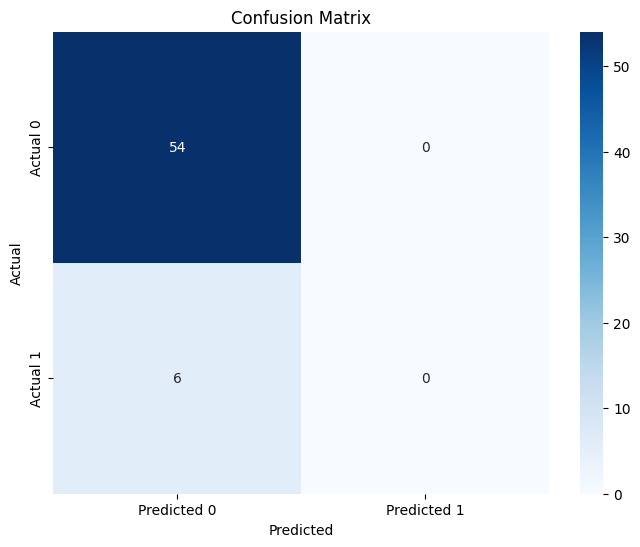

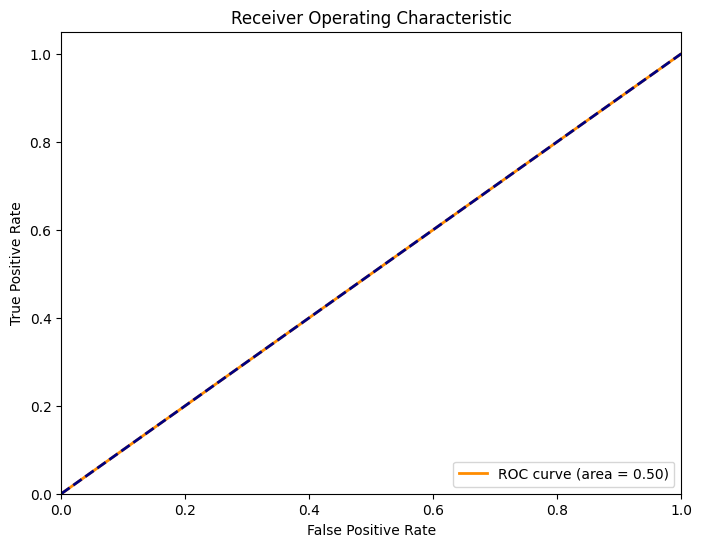

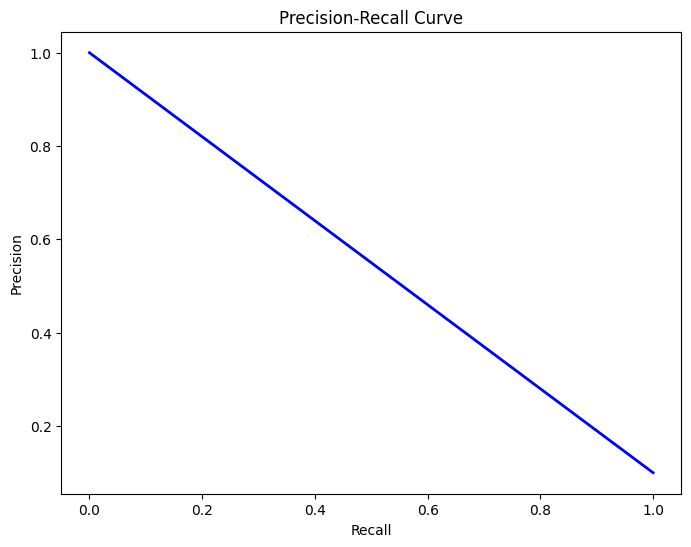

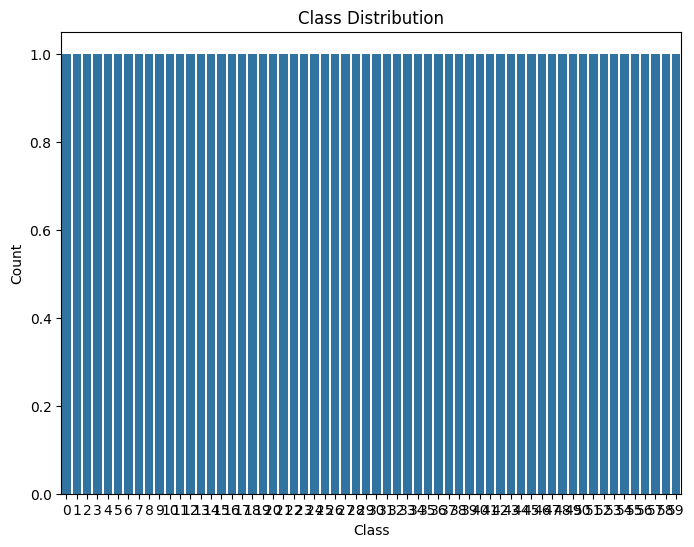

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Sample data
y_true = [0] * 54 + [1] * 6
y_pred = [0] * 60

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y_true)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('/content/sample.csv')

# Preprocess your data
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split data into features and target
X = data.drop('fraudRisk', axis=1)
y = data['fraudRisk']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the fitness function
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def fitness_function(particle):
    # No need to flatten the particle, keep it as a 2D array
    mask = (particle > 0.5)

    if np.sum(mask) == 0:
        return 1.0  # If no features are selected, return worst fitness

    X_selected = X_train[:, mask[0]] # Use mask[0] to index along the correct dimension
    model = create_model(X_selected.shape[1])
    model.fit(X_selected, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_selected, y_train, verbose=0)
    return 1.0 - accuracy  # We minimize the fitness, so return 1 - accuracy

In [ ]:
import numpy as np

# Define SSA parameters
n_salps = 30
n_features = X_train.shape[1]
max_iters = 100

# Initialize salps positions
salps = np.random.rand(n_salps, n_features)
best_cost = float('inf')
# Initialize best_position with an array of zeros
best_position = np.zeros(n_features)

# Define the SSA algorithm
def ssa_optimize(fitness_function, max_iters):
    global salps, best_cost, best_position # Declare salps as global
    for iter in range(max_iters):
        c1 = 2 * np.exp(-(4 * iter / max_iters)**2)  # Convergence factor
        for i in range(n_salps):
            if i == 0:  # Leader
                for j in range(n_features):
                    c2 = np.random.rand()
                    c3 = np.random.rand()
                    if c3 >= 0.5:
                        salps[i, j] = best_position[j] + c1 * ((ub - lb) * c2 + lb)
                    else:
                        salps[i, j] = best_position[j] - c1 * ((ub - lb) * c2 + lb)
            else:  # Followers
                salps[i] = (salps[i] + salps[i-1]) / 2

        # Clip salps positions
        salps = np.clip(salps, 0, 1)

        # Evaluate fitness
        for i in range(n_salps):
            cost = fitness_function(salps[i].reshape(1, -1))
            if cost < best_cost:
                best_cost = cost
                best_position = salps[i].copy()

    return best_cost, best_position

# Perform SSA optimization
# Define upper and lower bounds for feature selection (0 and 1 respectively)
ub = 1
lb = 0
best_cost, best_position = ssa_optimize(fitness_function, max_iters)

# Get the best features
best_features = np.where(best_position > 0.5)[0]
print("Selected features:", best_features)

KeyboardInterrupt: 

In [ ]:
!pip install pyswarm # Install the pyswarm module

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=dd8b4ef0fb08651743d2898e6bb3c420d1389e1db7b80115eb37033be5aad5a7
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pyswarm import pso

# Load the dataset
data = pd.read_csv('/content/sample.csv')

# Assuming the last column is the target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the objective function for SSA
def objective_function(features):
    # Convert the feature mask to integer indices
    selected_features = np.where(features > 0.5)[0]
    if len(selected_features) == 0:  # If no features are selected
        return 1.0  # Return the worst score (accuracy = 0)

    # Train a RandomForestClassifier on the selected features
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train[:, selected_features], y_train)
    y_pred = clf.predict(X_test[:, selected_features])

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Return the error (1 - accuracy) to minimize
    return 1 - accuracy

# Define the bounds for the features (binary selection)
lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]

# Run the Salp Swarm Algorithm
best_features, best_accuracy = pso(objective_function, lb, ub, swarmsize=30, maxiter=50, phip=0.5, phig=0.5, omega=0.5)

# Convert the binary mask to integer indices
selected_features = np.where(best_features > 0.5)[0]

# Print the selected features
print(f'Selected features: {selected_features}')
print(f'Best accuracy: {1 - best_accuracy}')


Stopping search: maximum iterations reached --> 50
Selected features: [0 1 7]
Best accuracy: 0.9166666666666666


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pyswarm import pso

# Load the dataset
data = pd.read_csv('/content/sample.csv')

# Assuming the last column is the target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the objective function for SSA
def objective_function(features):
    # Convert the feature mask to integer indices
    selected_features = np.where(features > 0.5)[0]
    if len(selected_features) == 0:  # If no features are selected
        return 1.0  # Return the worst score (accuracy = 0)

    # Initialize the Decision Tree classifier
    clf = DecisionTreeClassifier(random_state=42)

    # Train the classifier on the selected features
    clf.fit(X_train[:, selected_features], y_train)
    y_pred = clf.predict(X_test[:, selected_features])

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Return the error (1 - accuracy) to minimize
    return 1 - accuracy

# Define the bounds for the features (binary selection)
lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]

# Run the Salp Swarm Algorithm
best_features, best_accuracy = pso(objective_function, lb, ub, swarmsize=30, maxiter=50, phip=0.5, phig=0.5, omega=0.5)

# Convert the binary mask to integer indices
selected_features = np.where(best_features > 0.5)[0]

# Print the selected features
print(f'Selected features: {selected_features}')
print(f'Best accuracy: {1 - best_accuracy}')


Stopping search: maximum iterations reached --> 50
Selected features: [0 4 5 6 7]
Best accuracy: 0.9333333333333333


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pyswarm import pso

# Load the dataset
data = pd.read_csv('/content/sample.csv')

# Assuming the last column is the target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the objective function for SSA
def objective_function(features):
    # Convert the feature mask to integer indices
    selected_features = np.where(features > 0.5)[0]
    if len(selected_features) == 0:  # If no features are selected
        return 1.0  # Return the worst score (accuracy = 0)

    # Initialize the k-Nearest Neighbors classifier
    clf = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors as needed

    # Train the classifier on the selected features
    clf.fit(X_train[:, selected_features], y_train)
    y_pred = clf.predict(X_test[:, selected_features])

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Return the error (1 - accuracy) to minimize
    return 1 - accuracy

# Define the bounds for the features (binary selection)
lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]

# Run the Salp Swarm Algorithm
best_features, best_accuracy = pso(objective_function, lb, ub, swarmsize=30, maxiter=50, phip=0.5, phig=0.5, omega=0.5)

# Convert the binary mask to integer indices
selected_features = np.where(best_features > 0.5)[0]

# Print the selected features
print(f'Selected features: {selected_features}')
print(f'Best accuracy: {1 - best_accuracy}')


Stopping search: maximum iterations reached --> 50
Selected features: [0 2 4 5 6 7]
Best accuracy: 0.9


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pyswarm import pso

# Load the dataset
data = pd.read_csv('/content/sample.csv')

# Assuming the last column is the target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the objective function for SSA
def objective_function(features):
    # Convert the feature mask to integer indices
    selected_features = np.where(features > 0.5)[0]
    if len(selected_features) == 0:  # If no features are selected
        return 1.0  # Return the worst score (accuracy = 0)

    # Initialize the SVM classifier
    clf = SVC(kernel='rbf', gamma='scale', random_state=42)

    # Train the classifier on the selected features
    clf.fit(X_train[:, selected_features], y_train)
    y_pred = clf.predict(X_test[:, selected_features])

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Return the error (1 - accuracy) to minimize
    return 1 - accuracy

# Define the bounds for the features (binary selection)
lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]

# Run the Salp Swarm Algorithm
best_features, best_accuracy = pso(objective_function, lb, ub, swarmsize=30, maxiter=50, phip=0.5, phig=0.5, omega=0.5)

# Convert the binary mask to integer indices
selected_features = np.where(best_features > 0.5)[0]

# Print the selected features
print(f'Selected features: {selected_features}')
print(f'Best accuracy: {1 - best_accuracy}')


Stopping search: maximum iterations reached --> 50
Selected features: [1 6 7]
Best accuracy: 0.9


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from pyswarm import pso

# Load the dataset
data = pd.read_csv('/content/sample.csv')

# Assuming the last column is the target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the objective function for SSA with cross-validation
def objective_function(features):
    # Convert the feature mask to integer indices
    selected_features = np.where(features > 0.5)[0]
    if len(selected_features) == 0:  # If no features are selected
        return 1.0  # Return the worst score (accuracy = 0)

    # Initialize the SVM classifier
    clf = SVC(kernel='rbf', gamma='scale', random_state=42)

    # Perform k-fold cross-validation
    cv_scores = cross_val_score(clf, X[:, selected_features], y, cv=5)  # Adjust cv as needed

    # Calculate the mean accuracy
    mean_accuracy = np.mean(cv_scores)

    # Return the error (1 - mean_accuracy) to minimize
    return 1 - mean_accuracy

# Define the bounds for the features (binary selection)
lb = [0] * X.shape[1]
ub = [1] * X.shape[1]

# Run the Salp Swarm Algorithm
best_features, best_accuracy = pso(objective_function, lb, ub, swarmsize=30, maxiter=50, phip=0.5, phig=0.5, omega=0.5)

# Convert the binary mask to integer indices
selected_features = np.where(best_features > 0.5)[0]

# Print the selected features
print(f'Selected features: {selected_features}')
print(f'Best cross-validated accuracy: {1 - best_accuracy}')


Stopping search: maximum iterations reached --> 50
Selected features: [5 7]
Best cross-validated accuracy: 0.959871794871795


In [ ]:
pip install lazypredict


In [ ]:
import lazypredict

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('/content/Sample_Training_1.csv')

# Separate features and target
X = data.drop(columns=['fraudRisk'])
y = data['fraudRisk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


 97%|█████████▋| 28/29 [00:27<00:00,  2.21it/s]

[LightGBM] [Info] Number of positive: 613, number of negative: 9387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061300 -> initscore=-2.728716
[LightGBM] [Info] Start training from score -2.728716


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.90               0.86     0.86      0.92   
Perceptron                         0.92               0.80     0.80      0.93   
QuadraticDiscriminantAnalysis      0.94               0.76     0.76      0.94   
LinearDiscriminantAnalysis         0.95               0.76     0.76      0.95   
PassiveAggressiveClassifier        0.92               0.75     0.75      0.93   
GaussianNB                         0.93               0.75     0.75      0.94   
XGBClassifier                      0.95               0.73     0.73      0.95   
LGBMClassifier                     0.96               0.73     0.73      0.95   
AdaBoostClassifier                 0.95               0.72     0.72      0.95   
DecisionTreeClassifier             0.93               0.72     0.72      0.93   
LogisticRegression          

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

# Read the CSV file
data = pd.read_csv('/content/Sample_Train2.csv')

# Separate features and target
X = data.drop(columns=['TARGET'])
y = data['TARGET']

# Handle missing values by imputing with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Handle categorical variables using one-hot encoding
categorical_cols = X_imputed.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X_imputed[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns and append the encoded columns
X_imputed.drop(columns=categorical_cols, inplace=True)
X_final = pd.concat([X_imputed, X_encoded], axis=1)

# Check for missing values
print("Missing values in features:", X_final.isnull().sum().sum())
print("Missing values in target:", y.isnull().sum().sum())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier with verbose output
clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


Missing values in features: 0
Missing values in target: 0


  3%|▎         | 1/29 [00:21<10:06, 21.66s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.916, 'Balanced Accuracy': 0.5198222829801777, 'ROC AUC': 0.5198222829801776, 'F1 Score': 0.889929450369155, 'Time taken': 21.661049127578735}


  7%|▋         | 2/29 [00:40<09:04, 20.17s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.92, 'Balanced Accuracy': 0.49783549783549785, 'ROC AUC': 0.49783549783549785, 'F1 Score': 0.8855, 'Time taken': 19.1292405128479}


 10%|█         | 3/29 [00:45<05:39, 13.06s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 4.589192867279053}


 14%|█▍        | 4/29 [00:57<05:15, 12.64s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 11.982473611831665}


 17%|█▋        | 5/29 [00:59<03:33,  8.90s/it]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 21%|██        | 6/29 [01:05<03:01,  7.87s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.909, 'Balanced Accuracy': 0.516034404192299, 'ROC AUC': 0.5160344041922988, 'F1 Score': 0.8859099570135867, 'Time taken': 5.877884149551392}


 24%|██▍       | 7/29 [01:07<02:13,  6.06s/it]

{'Model': 'DummyClassifier', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 2.3394293785095215}


 28%|██▊       | 8/29 [01:10<01:45,  5.02s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.913, 'Balanced Accuracy': 0.5121610845295056, 'ROC AUC': 0.5121610845295056, 'F1 Score': 0.8867490569548522, 'Time taken': 2.7824132442474365}


 31%|███       | 9/29 [01:17<01:49,  5.50s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 6.543715000152588}


 34%|███▍      | 10/29 [01:20<01:32,  4.86s/it]

{'Model': 'GaussianNB', 'Accuracy': 0.901, 'Balanced Accuracy': 0.4875541125541126, 'ROC AUC': 0.4875541125541126, 'F1 Score': 0.8758800631246711, 'Time taken': 3.420604944229126}


 38%|███▊      | 11/29 [01:26<01:34,  5.27s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 6.198557376861572}


 41%|████▏     | 12/29 [01:32<01:32,  5.43s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 5.800837755203247}


 45%|████▍     | 13/29 [01:39<01:32,  5.76s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 6.507793188095093}


 48%|████▊     | 14/29 [02:00<02:38, 10.58s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 21.714560985565186}


 52%|█████▏    | 15/29 [02:07<02:11,  9.36s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.84, 'Balanced Accuracy': 0.49077238550922764, 'ROC AUC': 0.49077238550922764, 'F1 Score': 0.8484270520584195, 'Time taken': 6.537820339202881}


 55%|█████▌    | 16/29 [02:16<01:58,  9.14s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 8.6211256980896}


 59%|█████▊    | 17/29 [02:18<01:26,  7.22s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 2.7591259479522705}


 62%|██████▏   | 18/29 [02:21<01:03,  5.77s/it]

NuSVC model failed to execute
specified nu is infeasible


 66%|██████▌   | 19/29 [02:28<01:02,  6.28s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.839, 'Balanced Accuracy': 0.5083447254499885, 'ROC AUC': 0.5083447254499887, 'F1 Score': 0.8499488831417449, 'Time taken': 7.47342324256897}


 69%|██████▉   | 20/29 [02:31<00:48,  5.33s/it]

{'Model': 'Perceptron', 'Accuracy': 0.853, 'Balanced Accuracy': 0.5038448393711552, 'ROC AUC': 0.5038448393711552, 'F1 Score': 0.8567489892900206, 'Time taken': 3.119370460510254}


 72%|███████▏  | 21/29 [03:04<01:48, 13.52s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 32.60566282272339}


 76%|███████▌  | 22/29 [03:08<01:15, 10.84s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 4.567251920700073}


 79%|███████▉  | 23/29 [03:13<00:53,  8.86s/it]

{'Model': 'RidgeClassifier', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 4.248376131057739}


 83%|████████▎ | 24/29 [03:19<00:40,  8.02s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 6.06830358505249}


 86%|████████▌ | 25/29 [03:22<00:26,  6.52s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 3.0049262046813965}


 90%|████████▉ | 26/29 [04:44<01:27, 29.13s/it]

{'Model': 'SVC', 'Accuracy': 0.924, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8875010395010396, 'Time taken': 81.88942122459412}
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


 97%|█████████▋| 28/29 [05:03<00:20, 20.12s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.917, 'Balanced Accuracy': 0.5143255866940077, 'ROC AUC': 0.5143255866940077, 'F1 Score': 0.8889917273737499, 'Time taken': 19.227044105529785}
[LightGBM] [Info] Number of positive: 69, number of negative: 930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 891
[LightGBM] [Info] Number of data points in the train set: 999, number of used features: 297
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069069 -> initscore=-2.601078
[LightGBM] [Info] Start training from score -2.601078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [05:09<00:00, 10.66s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.923, 'Balanced Accuracy': 0.50549669628617, 'ROC AUC': 0.5054966962861699, 'F1 Score': 0.8888870907162014, 'Time taken': 5.637596607208252}
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.92               0.52     0.52      0.89   
DecisionTreeClassifier             0.91               0.52     0.52      0.89   
XGBClassifier                      0.92               0.51     0.51      0.89   
ExtraTreeClassifier                0.91               0.51     0.51      0.89   
PassiveAggressiveClassifier        0.84               0.51     0.51      0.85   
LGBMClassifier                     0.92               0.51     0.51      0.89   
Perceptron                         0.85               0.50     0.50      0.86   
DummyClassifier                    0.92               0.50     0.50      0.89   
ExtraTre

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('/content/Sample_Train3.csv')

# Separate features and target
X = data.drop(columns=['fraud'])
y = data['fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


100%|██████████| 29/29 [00:11<00:00,  2.62it/s]

[LightGBM] [Info] Number of positive: 397, number of negative: 4602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 4999, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079416 -> initscore=-2.450310
[LightGBM] [Info] Start training from score -2.450310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             1.00               0.99   

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('/content/Sample_Train4.csv')

# Separate features and target
X = data.drop(columns=['default payment next month'])
y = data['default payment next month']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


 97%|█████████▋| 28/29 [00:22<00:00,  1.80it/s]

[LightGBM] [Info] Number of positive: 1150, number of negative: 3849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3501
[LightGBM] [Info] Number of data points in the train set: 4999, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230046 -> initscore=-1.208051
[LightGBM] [Info] Start training from score -1.208051


100%|██████████| 29/29 [00:22<00:00,  1.27it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
GaussianNB                         0.67               0.66     0.66      0.70   
LGBMClassifier                     0.80               0.64     0.64      0.78   
XGBClassifier                      0.79               0.64     0.64      0.78   
BernoulliNB                        0.79               0.63     0.63      0.77   
RandomForestClassifier             0.81               0.63     0.63      0.78   
ExtraTreesClassifier               0.80               0.63     0.63      0.78   
AdaBoostClassifier                 0.80               0.62     0.62      0.77   
BaggingClassifier                  0.79               0.62     0.62      0.77   
SVC                                0.81               0.62     0.62      0.78   
KNeighborsClassifier               0.78               0.62     0.62      0.76   
NearestCentroid             

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('/content/Sample_Train5.csv')

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


 97%|█████████▋| 28/29 [00:19<00:00,  2.74it/s]

[LightGBM] [Info] Number of positive: 2518, number of negative: 2482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503600 -> initscore=0.014400
[LightGBM] [Info] Start training from score 0.014400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████| 29/29 [00:19<00:00,  1.45it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
LabelPropagation                   1.00               1.00     1.00      1.00   
LabelSpreading                     1.00               1.00     1.00      1.00   
SVC                                1.00               1.00     1.00      1.00   
LinearSVC                   

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Read the CSV file
data = pd.read_csv('/content/Sample_Train5.csv')

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Check for class imbalance
print("Class distribution in target variable:")
print(y.value_counts())

# Handle missing values by imputing with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Handle categorical variables using label encoding
categorical_cols = X_imputed.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X_imputed[col] = encoder.fit_transform(X_imputed[col])

# If there is class imbalance, balance the classes by downsampling the majority class
min_class = y.value_counts().idxmin()
maj_class = y.value_counts().idxmax()
if y.value_counts()[min_class] / y.value_counts()[maj_class] < 0.5:
    X_imputed['Class'] = y
    minority = X_imputed[X_imputed['Class'] == min_class]
    majority = X_imputed[X_imputed['Class'] == maj_class]

    # Downsample majority class
    majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=123)

    # Combine minority class with downsampled majority class
    balanced_data = pd.concat([minority, majority_downsampled])

    # Separate features and target after downsampling
    X_imputed = balanced_data.drop(columns=['Class'])
    y = balanced_data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


Class distribution in target variable:
Class
1    5004
0    4997
Name: count, dtype: int64


 97%|█████████▋| 28/29 [00:15<00:00,  3.32it/s]

[LightGBM] [Info] Number of positive: 2518, number of negative: 2482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503600 -> initscore=0.014400
[LightGBM] [Info] Start training from score 0.014400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
LabelPropagation                   1.00               1.00     1.00      1.00   
LabelSpreading                     1.00               1.00     1.00      1.00   
SVC                                1.00               1.00     1.00      1.00   
LinearSVC                   

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Read the CSV file
data = pd.read_csv('/content/Sample_Train6.csv')

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Check for class imbalance
print("Class distribution in target variable:")
print(y.value_counts())

# Handle missing values by imputing with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Handle categorical variables using label encoding
categorical_cols = X_imputed.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X_imputed[col] = encoder.fit_transform(X_imputed[col])

# If there is class imbalance, balance the classes by downsampling the majority class
min_class = y.value_counts().idxmin()
maj_class = y.value_counts().idxmax()
if y.value_counts()[min_class] / y.value_counts()[maj_class] < 0.5:
    X_imputed['Class'] = y
    minority = X_imputed[X_imputed['Class'] == min_class]
    majority = X_imputed[X_imputed['Class'] == maj_class]

    # Downsample majority class
    majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=123)

    # Combine minority class with downsampled majority class
    balanced_data = pd.concat([minority, majority_downsampled])

    # Separate features and target after downsampling
    X_imputed = balanced_data.drop(columns=['Class'])
    y = balanced_data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


Class distribution in target variable:
Class
0    9961
1      38
Name: count, dtype: int64


100%|██████████| 29/29 [00:01<00:00, 24.85it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 20, number of negative: 18
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526316 -> initscore=0.105361
[LightGBM] [Info] Start training from score 0.105361
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Read the CSV file
data = pd.read_csv('/content/Sample_Train7.csv')

# Separate features and target
X = data.drop(columns=['NFLAG_INSURED_ON_APPROVAL'])
y = data['NFLAG_INSURED_ON_APPROVAL']

# Check for class imbalance
print("Class distribution in target variable:")
print(y.value_counts())

# Handle missing values by imputing with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Handle categorical variables using label encoding
categorical_cols = X_imputed.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X_imputed[col] = encoder.fit_transform(X_imputed[col])

# If there is class imbalance, balance the classes by downsampling the majority class
min_class = y.value_counts().idxmin()
maj_class = y.value_counts().idxmax()
if y.value_counts()[min_class] / y.value_counts()[maj_class] < 0.5:
    X_imputed['NFLAG_INSURED_ON_APPROVAL'] = y
    minority = X_imputed[X_imputed['NFLAG_INSURED_ON_APPROVAL'] == min_class]
    majority = X_imputed[X_imputed['NFLAG_INSURED_ON_APPROVAL'] == maj_class]

    # Downsample majority class
    majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=123)

    # Combine minority class with downsampled majority class
    balanced_data = pd.concat([minority, majority_downsampled])

    # Separate features and target after downsampling
    X_imputed = balanced_data.drop(columns=['NFLAG_INSURED_ON_APPROVAL'])
    y = balanced_data['NFLAG_INSURED_ON_APPROVAL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


Class distribution in target variable:
NFLAG_INSURED_ON_APPROVAL
0.00    4155
1.00    1988
Name: count, dtype: int64


 97%|█████████▋| 28/29 [00:12<00:00,  1.84it/s]

[LightGBM] [Info] Number of positive: 994, number of negative: 994
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 1988, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.90               0.90     0.90      0.90   
XGBClassifier                      0.90               0.90     0.90      0.90   
ExtraTreesClassifier               0.88               0.88     0.88      0.88   
RandomForestClassifier             0.88               0.88     0.88      0.88   
BaggingClassifier                  0.87               0.87     0.87      0.87   
AdaBoostClassifier                 0.87               0.87     0.87      0.87   
SVC                                0.87               0.87     0.87      0.87   
NuSVC                              0.86               0.86     0.86      0.85   
DecisionTreeClassifier             0.85               0.85     0.85      0.85   
CalibratedClassifierCV             0.85               0.85     0.85      0.85   
LinearSVC                   

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('/content/Sample_Train8.csv')

# Separate features and target
X = data.drop(columns=['targets'])
y = data['targets']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)

 97%|█████████▋| 28/29 [00:29<00:00,  2.05it/s]

[LightGBM] [Info] Number of positive: 980, number of negative: 4020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4258
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196000 -> initscore=-1.411485
[LightGBM] [Info] Start training from score -1.411485


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.93               0.87     0.87      0.93   
XGBClassifier                      0.93               0.86     0.86      0.92   
ExtraTreesClassifier               0.93               0.85     0.85      0.92   
DecisionTreeClassifier             0.90               0.84     0.84      0.90   
AdaBoostClassifier                 0.92               0.84     0.84      0.91   
BaggingClassifier                  0.91               0.84     0.84      0.91   
RandomForestClassifier             0.92               0.84     0.84      0.92   
BernoulliNB                        0.86               0.83     0.83      0.86   
KNeighborsClassifier               0.90               0.81     0.81      0.89   
ExtraTreeClassifier                0.88               0.81     0.81      0.88   
Perceptron                  

In [ ]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Read the CSV file
data = pd.read_csv('/content/Sample_Train10.csv')

# Separate features and target
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Handle missing values by imputing with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Handle categorical variables using label encoding
categorical_cols = X_imputed.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X_imputed[col] = encoder.fit_transform(X_imputed[col])

# Combine the features and target to downsample
data_balanced = pd.concat([X_imputed, y], axis=1)

# Separate majority and minority classes
majority = data_balanced[data_balanced.isFraud == 0]
minority = data_balanced[data_balanced.isFraud == 1]

# Downsample majority class
majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=123)

# Combine minority class with downsampled majority class
data_balanced = pd.concat([minority, majority_downsampled])

# Separate features and target after downsampling
X_balanced = data_balanced.drop(columns=['isFraud'])
y_balanced = data_balanced['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.5, random_state=123)

# Initialize and fit the LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models
print(models)


  7%|▋         | 2/29 [00:00<00:05,  4.96it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.8529411764705882, 'Balanced Accuracy': 0.8529411764705882, 'ROC AUC': 0.8529411764705882, 'F1 Score': 0.8528138528138528, 'Time taken': 0.27858662605285645}
{'Model': 'BaggingClassifier', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764707, 'F1 Score': 0.8822510822510822, 'Time taken': 0.1376950740814209}
{'Model': 'BernoulliNB', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8822510822510822, 'Time taken': 0.04861927032470703}

 14%|█▍        | 4/29 [00:00<00:03,  7.30it/s]


{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8822510822510822, 'Time taken': 0.1367206573486328}


 24%|██▍       | 7/29 [00:00<00:01, 11.74it/s]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.8382352941176471, 'Balanced Accuracy': 0.838235294117647, 'ROC AUC': 0.8382352941176471, 'F1 Score': 0.837919826652221, 'Time taken': 0.06190061569213867}
{'Model': 'DummyClassifier', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3333333333333333, 'Time taken': 0.05892539024353027}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.8529411764705882, 'Balanced Accuracy': 0.8529411764705882, 'ROC AUC': 0.8529411764705882, 'F1 Score': 0.8517872711421098, 'Time taken': 0.05339980125427246}


 38%|███▊      | 11/29 [00:01<00:02,  8.24it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9117647058823529, 'Balanced Accuracy': 0.9117647058823529, 'ROC AUC': 0.9117647058823529, 'F1 Score': 0.9117647058823528, 'Time taken': 0.47069573402404785}
{'Model': 'GaussianNB', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8822510822510822, 'Time taken': 0.04549908638000488}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.8235294117647058, 'Balanced Accuracy': 0.8235294117647058, 'ROC AUC': 0.8235294117647058, 'F1 Score': 0.8210526315789475, 'Time taken': 0.07999873161315918}
{'Model': 'LabelPropagation', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8822510822510822, 'Time taken': 0.07002091407775879}


 52%|█████▏    | 15/29 [00:01<00:01, 10.41it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8822510822510822, 'Time taken': 0.08706307411193848}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8819444444444443, 'Time taken': 0.07993960380554199}
{'Model': 'LinearSVC', 'Accuracy': 0.9117647058823529, 'Balanced Accuracy': 0.9117647058823529, 'ROC AUC': 0.9117647058823529, 'F1 Score': 0.9117647058823528, 'Time taken': 0.05282735824584961}


 66%|██████▌   | 19/29 [00:01<00:00, 12.64it/s]

{'Model': 'LogisticRegression', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8822510822510822, 'Time taken': 0.09155011177062988}
{'Model': 'NearestCentroid', 'Accuracy': 0.8235294117647058, 'Balanced Accuracy': 0.8235294117647058, 'ROC AUC': 0.8235294117647058, 'F1 Score': 0.8221447253705321, 'Time taken': 0.056699275970458984}
{'Model': 'NuSVC', 'Accuracy': 0.8676470588235294, 'Balanced Accuracy': 0.8676470588235294, 'ROC AUC': 0.8676470588235293, 'F1 Score': 0.86738894907909, 'Time taken': 0.05018734931945801}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764707, 'F1 Score': 0.8822510822510822, 'Time taken': 0.051480770111083984}


 72%|███████▏  | 21/29 [00:02<00:00, 14.01it/s]

{'Model': 'Perceptron', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8823529411764706, 'Time taken': 0.05196118354797363}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.8235294117647058, 'Balanced Accuracy': 0.8235294117647058, 'ROC AUC': 0.8235294117647058, 'F1 Score': 0.8221447253705321, 'Time taken': 0.05068087577819824}


 90%|████████▉ | 26/29 [00:03<00:00,  8.53it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.8676470588235294, 'Balanced Accuracy': 0.8676470588235294, 'ROC AUC': 0.8676470588235294, 'F1 Score': 0.8676184295911744, 'Time taken': 0.7434008121490479}
{'Model': 'RidgeClassifier', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8819444444444443, 'Time taken': 0.042724609375}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.8676470588235294, 'Balanced Accuracy': 0.8676470588235294, 'ROC AUC': 0.8676470588235293, 'F1 Score': 0.86738894907909, 'Time taken': 0.024532318115234375}
{'Model': 'SGDClassifier', 'Accuracy': 0.8235294117647058, 'Balanced Accuracy': 0.8235294117647058, 'ROC AUC': 0.8235294117647058, 'F1 Score': 0.8233766233766234, 'Time taken': 0.04708385467529297}
{'Model': 'SVC', 'Accuracy': 0.8823529411764706, 'Balanced Accuracy': 0.8823529411764706, 'ROC AUC': 0.8823529411764706, 'F1 Score': 0.8822510822510822, 'Time taken': 0.023407697677612305}


100%|██████████| 29/29 [00:03<00:00,  7.83it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.8676470588235294, 'Balanced Accuracy': 0.8676470588235294, 'ROC AUC': 0.8676470588235294, 'F1 Score': 0.8676184295911744, 'Time taken': 0.489729642868042}
[LightGBM] [Info] Number of positive: 34, number of negative: 34
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [ ]:
####################################################################################################

In [ ]:
# import the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv1D,BatchNormalization,Dropout

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout# import the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv1D,BatchNormalization,Dropout

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

In [ ]:
credit =pd.read_csv("/content/Sample_Train2.csv")
print(credit.head())

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

In [ ]:
print(credit.isnull().sum())
print(credit['TARGET'].value_counts())

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
                             ... 
AMT_REQ_CREDIT_BUREAU_DAY     291
AMT_REQ_CREDIT_BUREAU_WEEK    291
AMT_REQ_CREDIT_BUREAU_MON     291
AMT_REQ_CREDIT_BUREAU_QRT     291
AMT_REQ_CREDIT_BUREAU_YEAR    291
Length: 122, dtype: int64
TARGET
0    1854
1     145
Name: count, dtype: int64


In [ ]:
non_fraud = credit[credit['TARGET'] == 0]
fraud = credit[credit['TARGET'] == 1]
print(credit['TARGET'].value_counts())

TARGET
0    1854
1     145
Name: count, dtype: int64


In [ ]:
print(non_fraud.shape, fraud.shape)


(1854, 122) (145, 122)


In [ ]:
credit = pd.concat([fraud, non_fraud], ignore_index=True)
print(credit.head())

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100031       1         Cash loans           F            N   
2      100047       1         Cash loans           M            N   
3      100049       1         Cash loans           F            N   
4      100096       1         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               Y             0          112500.0    979992.0      27076.5   
2               Y             0          202500.0   1193580.0      35028.0   
3               N             0          135000.0    288873.0      16258.5   
4               Y             0           81000.0    252000.0      14593.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

In [ ]:
# now dividing the dataframe into dependent and independent varaible
X=credit.drop(['TARGET'], axis=1)
y=credit.TARGET

# check the shape
print(X.shape, y.shape)

(1999, 121) (1999,)


In [ ]:
# Define the objective function
def objective_function(feature_subset):
    selected_features = np.where(feature_subset > 0.5)[0]
    if len(selected_features) == 0:
        return 1e6  # Penalize empty selection

    X_selected = X.iloc[:, selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=99)

    # Handle non-numeric values before conversion
    X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dropout(0.5),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, verbose=0)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return 1 - accuracy

In [ ]:
# Initialize SSA parameters
population_size = 30
max_iter = 10
dim = X.shape[1]

# Apply SSA for feature selection
ssa = SalpSwarmAlgorithm(objective_function, dim, population_size, max_iter)
best_features = ssa.run()

selected_features = np.where(best_features > 0.5)[0]
print("Selected features:", selected_features)



Selected features: [  0   3   4   8   9  10  12  14  15  16  17  19  20  23  24  25  28  30
  31  32  33  38  42  43  47  48  52  53  54  56  57  62  65  67  68  71
  73  78  79  80  82  83  85  86  91  92  93  94  96  97  99 102 104 107
 110 117 118 120]


In [ ]:
# Update the dataset with selected features
X_selected = X.iloc[:, selected_features]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=99)

# Identify columns with non-numeric values in X_train
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns

# Handle non-numeric columns (example: fill with a placeholder or encode)
for col in non_numeric_cols:
    X_train[col] = X_train[col].fillna('unknown')  # Replace 'N' or NaNs with 'unknown'
    X_test[col] = X_test[col].fillna('unknown')

# Convert all columns to numeric (if necessary)
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data to fit the CNN input requirements
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1599, 58, 1)
Testing data shape: (400, 58, 1)


In [ ]:
# Define the model
model = Sequential()

# Input layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add hidden layers
for _ in range(9):
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Dropout(0.5))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Model: "sequential_656"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_656 (Conv1D)         (None, 58, 64)            128       
                                                                 
 conv1d_657 (Conv1D)         (None, 58, 64)            4160      
                                                                 
 dropout_1312 (Dropout)      (None, 58, 64)            0         
                                                                 
 conv1d_658 (Conv1D)         (None, 58, 64)            4160      
                                                                 
 dropout_1313 (Dropout)      (None, 58, 64)            0         
                                                                 
 conv1d_659 (Conv1D)         (None, 58, 64)            4160      
                                                                 
 dropout_1314 (Dropout)      (None, 58, 64)         

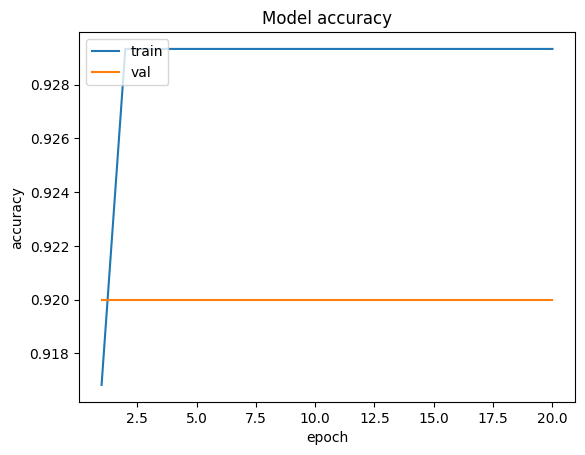

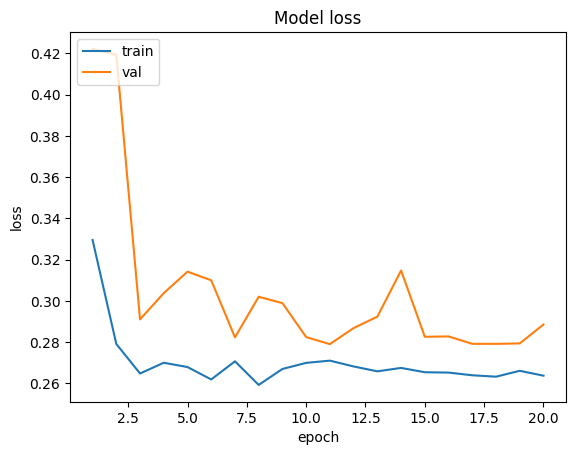

In [ ]:
# Plot the learning curve
def plot_learningcurve(history, epochs):
    epoch = range(1, epochs + 1)
    # accuracy
    plt.plot(epoch, history.history['accuracy'])
    plt.plot(epoch, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # loss
    plt.plot(epoch, history.history['loss'])
    plt.plot(epoch, history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_learningcurve(history, 20)


In [ ]:
#################################################################################################################################################################

In [ ]:
# import the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv1D,BatchNormalization,Dropout

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout# import the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv1D,BatchNormalization,Dropout

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

In [ ]:
credit =pd.read_csv("/content/Sample_Train4.csv")
print(credit.head())

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0   

In [ ]:
print(credit.isnull().sum())
print(credit['default payment next month'].value_counts())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64
default payment next month
0    7740
1    2259
Name: count, dtype: int64


In [ ]:
non_fraud = credit[credit['default payment next month'] == 0]
fraud = credit[credit['default payment next month'] == 1]
print(credit['default payment next month'].value_counts())

default payment next month
0    7740
1    2259
Name: count, dtype: int64


In [ ]:
print(non_fraud.shape, fraud.shape)

(7740, 25) (2259, 25)


In [ ]:
credit = pd.concat([fraud, non_fraud], ignore_index=True)
print(credit.head(15))

    ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    1      20000    2          2         1   24      2      2     -1     -1   
1    2     120000    2          2         2   26     -1      2      0      0   
2   14      70000    1          2         2   30      1      2      2      0   
3   17      20000    1          1         2   24      0      0      2      2   
4   22     120000    2          2         1   39     -1     -1     -1     -1   
5   23      70000    2          2         2   26      2      0      0      2   
6   24     450000    2          1         1   40     -2     -2     -2     -2   
7   27      60000    1          1         2   27      1     -2     -1     -1   
8   32      50000    1          2         2   33      2      0      0      0   
9   39      50000    1          1         2   25      1     -1     -1     -2   
10  46     210000    1          1         2   29     -2     -2     -2     -2   
11  47      20000    2          1       

In [ ]:
# now dividing the dataframe into dependent and independent variables
X = credit.drop(['default payment next month'], axis=1)
y = credit['default payment next month']

# check the shape
print(X.shape, y.shape)

(9999, 24) (9999,)


In [ ]:
class SalpSwarmAlgorithm:
    def __init__(self, obj_func, dim, population_size, max_iter):
        self.obj_func = obj_func
        self.dim = dim
        self.population_size = population_size
        self.max_iter = max_iter

    def initialize_population(self):
        population = np.random.rand(self.population_size, self.dim)
        return population

    def fitness(self, population):
        fitness_values = np.array([self.obj_func(ind) for ind in population])
        return fitness_values

    def update_position(self, population, leader_position):
        for i in range(1, self.population_size):
            for j in range(self.dim):
                c1 = np.random.rand()
                c2 = np.random.rand()
                population[i, j] = c1 * (leader_position[j] - population[i, j]) + c2 * (population[i, j] - leader_position[j])
        return population

    def run(self):
        population = self.initialize_population()
        fitness_values = self.fitness(population)
        leader_position = population[np.argmin(fitness_values)]
        leader_fitness = np.min(fitness_values)

        for t in range(self.max_iter):
            population = self.update_position(population, leader_position)
            fitness_values = self.fitness(population)
            if np.min(fitness_values) < leader_fitness:
                leader_position = population[np.argmin(fitness_values)]
                leader_fitness = np.min(fitness_values)

        return leader_position

# Define the objective function
def objective_function(feature_subset):
    selected_features = np.where(feature_subset > 0.1)[0]
    if len(selected_features) == 0:
        return 1e6  # Penalize empty selection

    X_selected = X.iloc[:, selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=99)

    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dropout(0.5),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, verbose=0)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return 1 - accuracy


In [ ]:
# Initialize SSA parameters
population_size = 30
max_iter = 10
dim = X.shape[1]

# Apply SSA for feature selection
ssa = SalpSwarmAlgorithm(objective_function, dim, population_size, max_iter)
best_features = ssa.run()

selected_features = np.where(best_features > 0)[0]
print("Selected features:", selected_features)



Selected features: []


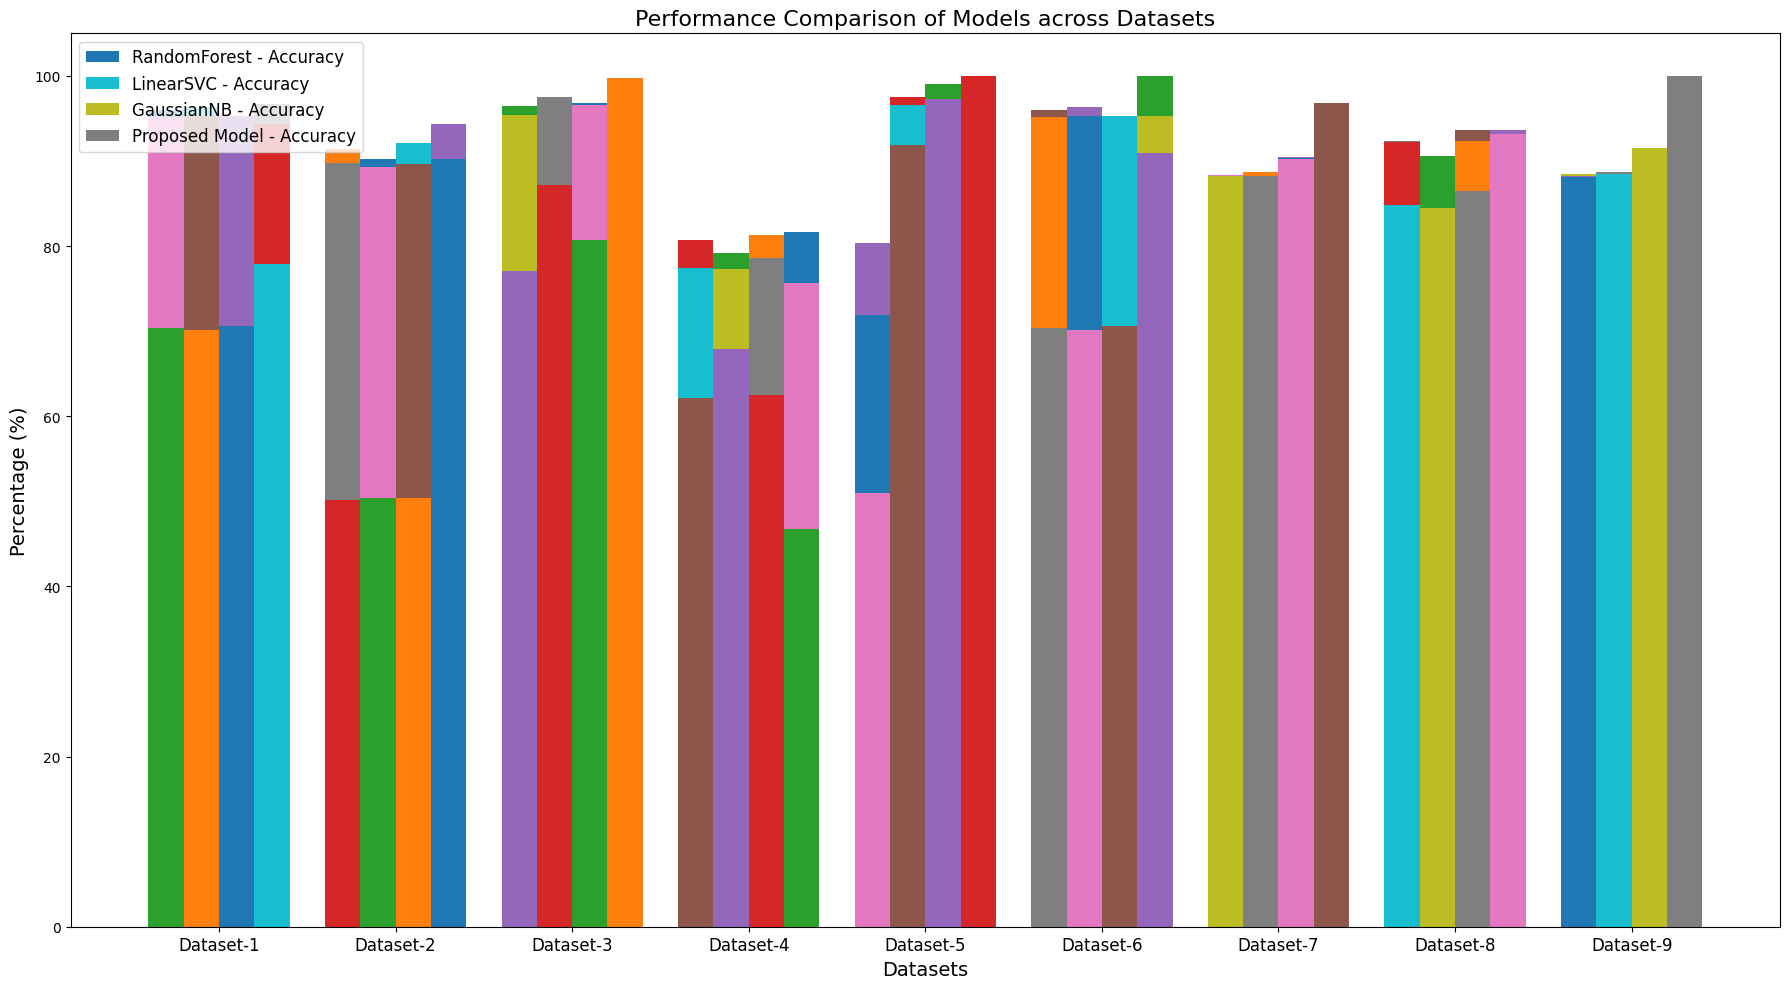

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Dataset names, model names, accuracy, f1-score, and AUC
datasets = ['Dataset-1', 'Dataset-2', 'Dataset-3', 'Dataset-4', 'Dataset-5', 'Dataset-6', 'Dataset-7', 'Dataset-8', 'Dataset-9']
models = ['RandomForest', 'LinearSVC', 'GaussianNB', 'Proposed Model']

# Accuracy, F1-score, and AUC for each model per dataset (example values provided, replace with your data)
accuracy = [
    [96.03, 96.32, 93.71, 96.72],
    [91.43, 90.23, 92.14, 94.33],
    [96.46, 97.22, 96.82, 99.37],
    [80.73, 79.22, 81.28, 81.65],
    [80.32, 97.46, 99.03, 99.96],
    [96.03, 96.32, 93.71, 99.94],
    [88.36, 88.68, 90.49, 92.65],
    [92.35, 90.26, 93.63, 93.63],
    [88.48, 88.72, 91.29, 100.00]
]

f1_score = [
    [95.12, 95.31, 95.31, 94.37],
    [89.76, 89.25, 89.62, 94.32],
    [95.42, 97.51, 96.62, 96.44],
    [77.42, 77.35, 78.57, 75.64],
    [71.87, 96.63, 96.59, 99.87],
    [95.12, 95.31, 95.31, 95.23],
    [88.27, 88.73, 90.37, 87.43],
    [92.27, 90.63, 92.37, 75.14],
    [88.23, 88.39, 91.34, 100.00]
]

auc = [
    [70.35, 70.11, 70.64, 77.84],
    [50.12, 50.33, 50.36, 90.18],
    [77.09, 87.23, 80.75, 99.79],
    [62.09, 67.93, 62.48, 46.73],
    [50.99, 91.89, 97.26, 99.94],
    [70.35, 70.11, 70.64, 90.90],
    [88.19, 88.26, 90.28, 96.80],
    [84.84, 84.47, 86.48, 93.11],
    [88.07, 88.52, 91.58, 100.00]
]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(18, 10))

# Number of datasets and models
num_datasets = len(datasets)
num_models = len(models)

# Bar width
bar_width = 0.2

# Positions of bars on x-axis
indices = np.arange(num_datasets)
bar_positions = [indices + bar_width * i for i in range(num_models)]

for i, (metric, metric_label) in enumerate(zip([accuracy, f1_score, auc], ['Accuracy', 'F1-score', 'AUC'])):
    for j in range(num_models):
        # Iterate over the metric values for the current model
        for k in range(num_datasets):
            ax.bar(bar_positions[j][k], metric[k][j], bar_width, label=f'{models[j]} - {metric_label}' if i == 0 and k == 0 else "")
            # The label is only added for the first bar of each model to avoid duplicates in the legend.

# Adding labels and title
ax.set_xlabel('Datasets', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_title('Performance Comparison of Models across Datasets', fontsize=16)
ax.set_xticks(indices + bar_width * (num_models - 1) / 2)
ax.set_xticklabels(datasets, fontsize=12)
ax.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


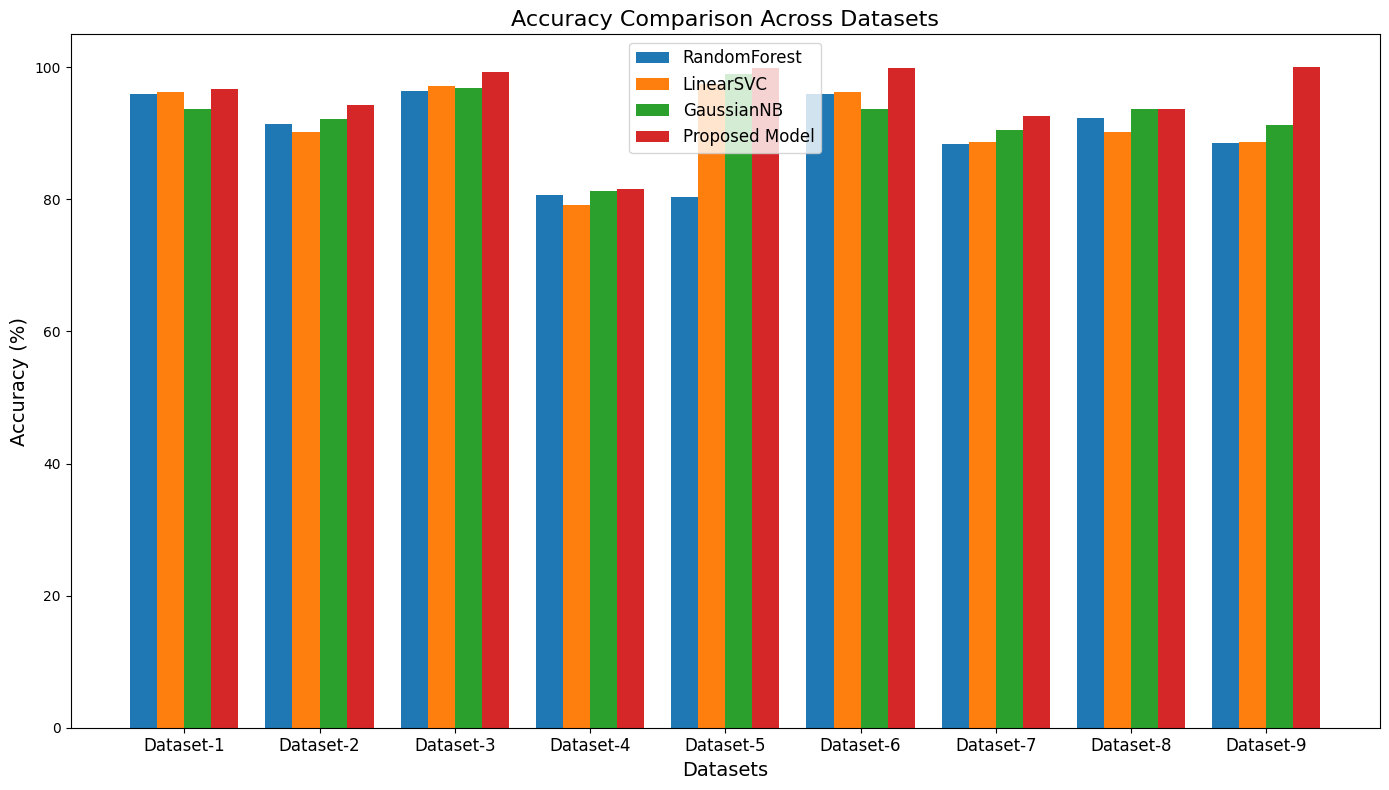

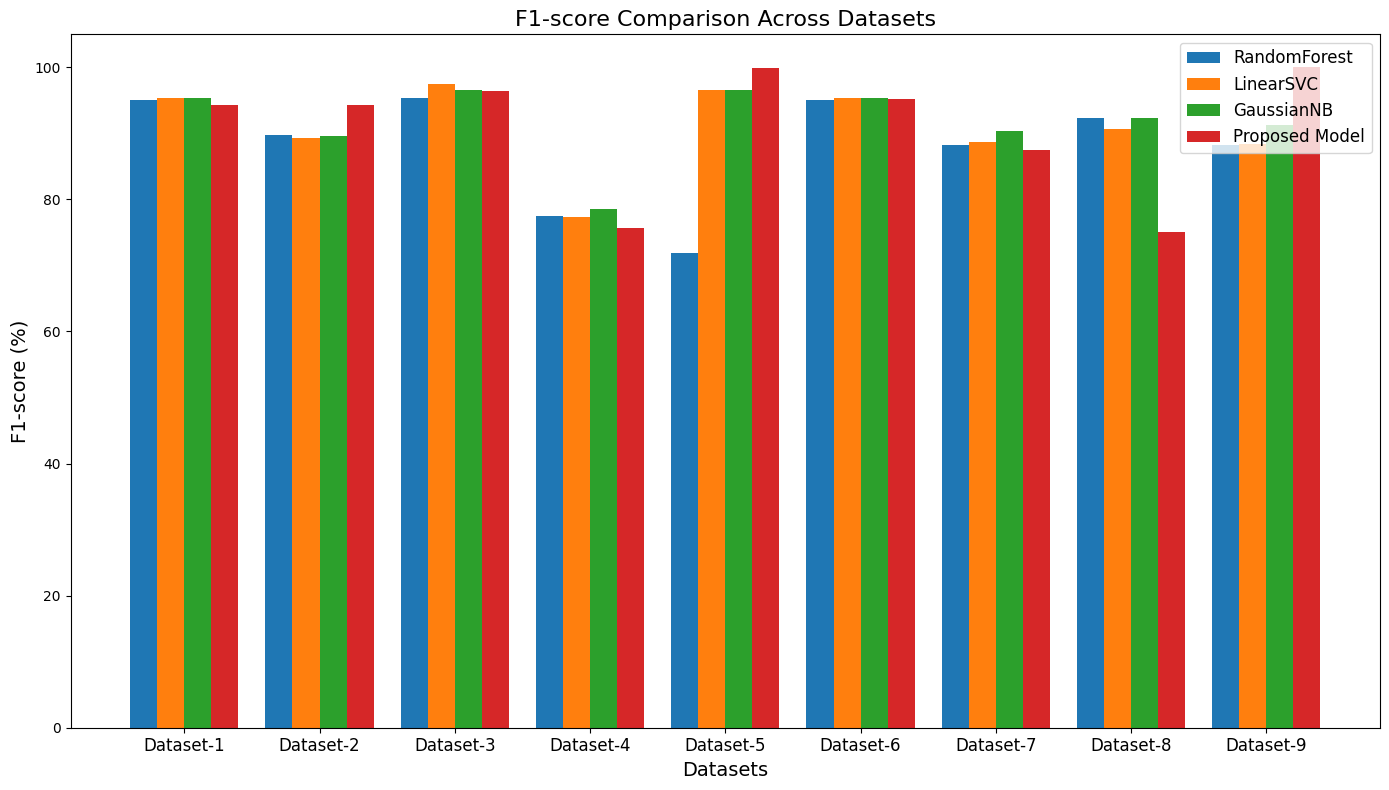

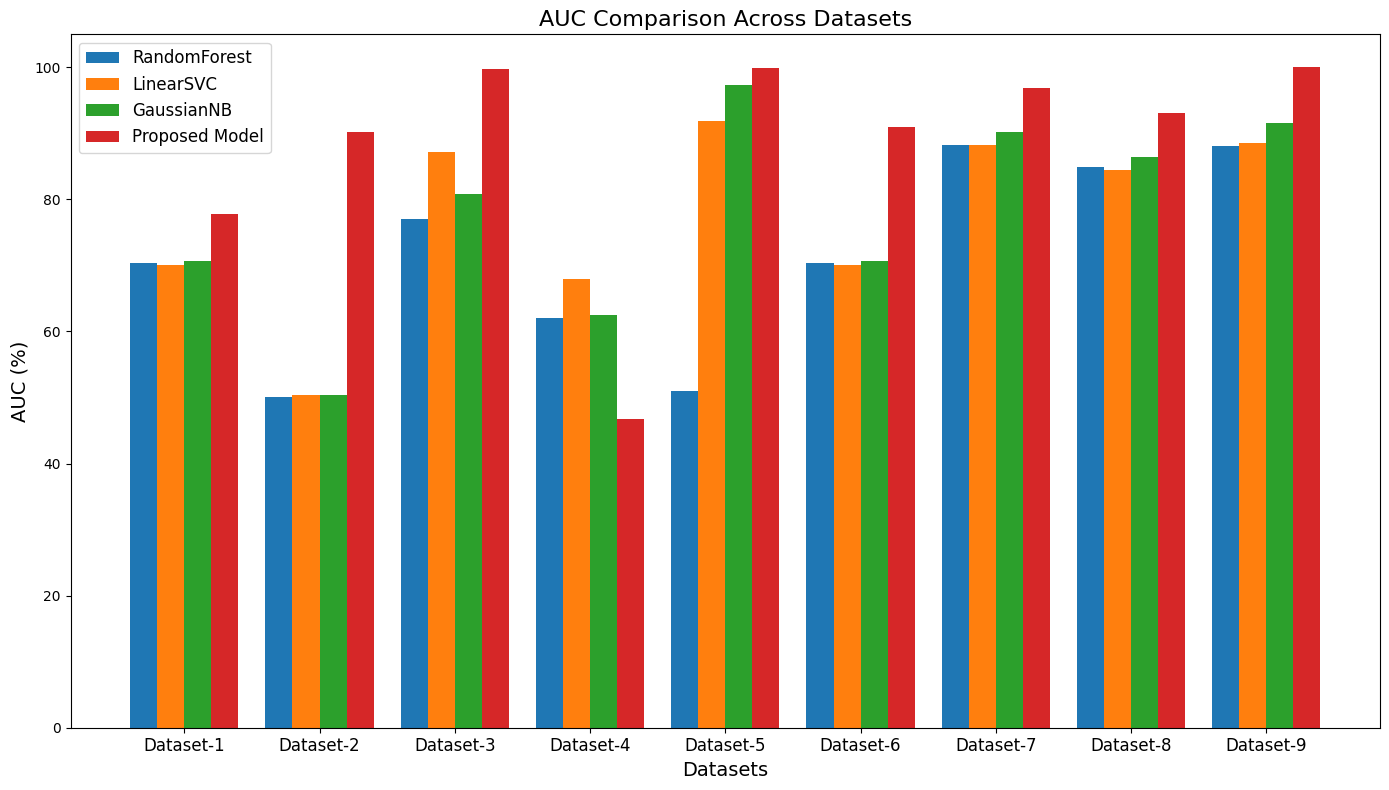

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Dataset names, model names, accuracy, f1-score, and AUC
datasets = ['Dataset-1', 'Dataset-2', 'Dataset-3', 'Dataset-4', 'Dataset-5', 'Dataset-6', 'Dataset-7', 'Dataset-8', 'Dataset-9']
models = ['RandomForest', 'LinearSVC', 'GaussianNB', 'Proposed Model']

# Accuracy, F1-score, and AUC for each model per dataset
accuracy = np.array([
    [96.03, 96.32, 93.71, 96.72],
    [91.43, 90.23, 92.14, 94.33],
    [96.46, 97.22, 96.82, 99.37],
    [80.73, 79.22, 81.28, 81.65],
    [80.32, 97.46, 99.03, 99.96],
    [96.03, 96.32, 93.71, 99.94],
    [88.36, 88.68, 90.49, 92.65],
    [92.35, 90.26, 93.63, 93.63],
    [88.48, 88.72, 91.29, 100.00]
])

f1_score = np.array([
    [95.12, 95.31, 95.31, 94.37],
    [89.76, 89.25, 89.62, 94.32],
    [95.42, 97.51, 96.62, 96.44],
    [77.42, 77.35, 78.57, 75.64],
    [71.87, 96.63, 96.59, 99.87],
    [95.12, 95.31, 95.31, 95.23],
    [88.27, 88.73, 90.37, 87.43],
    [92.27, 90.63, 92.37, 75.14],
    [88.23, 88.39, 91.34, 100.00]
])

auc = np.array([
    [70.35, 70.11, 70.64, 77.84],
    [50.12, 50.33, 50.36, 90.18],
    [77.09, 87.23, 80.75, 99.79],
    [62.09, 67.93, 62.48, 46.73],
    [50.99, 91.89, 97.26, 99.94],
    [70.35, 70.11, 70.64, 90.90],import matplotlib.pyplot as plt
import numpy as np

# Data: Dataset names, model names, accuracy, f1-score, and AUC
datasets = ['Dataset-1', 'Dataset-2', 'Dataset-3', 'Dataset-4', 'Dataset-5', 'Dataset-6', 'Dataset-7', 'Dataset-8', 'Dataset-9']
models = ['RandomForest', 'LinearSVC', 'GaussianNB', 'Proposed Model']

# Accuracy, F1-score, and AUC for each model per dataset
accuracy = np.array([
    [96.03, 96.32, 93.71, 96.72],
    [91.43, 90.23, 92.14, 94.33],
    [96.46, 97.22, 96.82, 99.37],
    [80.73, 79.22, 81.28, 81.65],
    [80.32, 97.46, 99.03, 99.96],
    [96.03, 96.32, 93.71, 99.94],
    [88.36, 88.68, 90.49, 92.65],
    [92.35, 90.26, 93.63, 93.63],
    [88.48, 88.72, 91.29, 100.00]
])

f1_score = np.array([
    [95.12, 95.31, 95.31, 94.37],
    [89.76, 89.25, 89.62, 94.32],
    [95.42, 97.51, 96.62, 96.44],
    [77.42, 77.35, 78.57, 75.64],
    [71.87, 96.63, 96.59, 99.87],
    [95.12, 95.31, 95.31, 95.23],
    [88.27, 88.73, 90.37, 87.43],
    [92.27, 90.63, 92.37, 75.14],
    [88.23, 88.39, 91.34, 100.00]
])

auc = np.array([
    [70.35, 70.11, 70.64, 77.84],
    [50.12, 50.33, 50.36, 90.18],
    [77.09, 87.23, 80.75, 99.79],
    [62.09, 67.93, 62.48, 46.73],
    [50.99, 91.89, 97.26, 99.94],
    [70.35, 70.11, 70.64, 90.90],
    [88.19, 88.26, 90.28, 96.80],
    [84.84, 84.47, 86.48, 93.11],
    [88.07, 88.52, 91.58, 100.00]
])

# Bar width and positions for grouped bars
bar_width = 0.2
indices = np.arange(len(datasets))
bar_positions = [indices + bar_width * i for i in range(len(models))]

# Function to create bar plots for each metric
def plot_metric(metric_data, metric_name, show_legend=True):
    plt.figure(figsize=(14, 8))
    for i in range(len(models)):
        plt.bar(bar_positions[i], metric_data[:, i], bar_width, label=models[i])
    plt.xlabel('Datasets', fontsize=14)
    plt.ylabel(f'{metric_name} (%)', fontsize=14)
    plt.title(f'{metric_name} Comparison Across Datasets', fontsize=16)
    plt.xticks(indices + bar_width * (len(models) - 1) / 2, datasets, fontsize=12)
    if show_legend:
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plotting each metric separately
plot_metric(accuracy, 'Accuracy', show_legend=False)
plot_metric(f1_score, 'F1-score', show_legend=False)
plot_metric(auc, 'AUC', show_legend=True)

    [88.19, 88.26, 90.28, 96.80],
    [84.84, 84.47, 86.48, 93.11],
    [88.07, 88.52, 91.58, 100.00]
])

# Bar width and positions for grouped bars
bar_width = 0.2
indices = np.arange(len(datasets))
bar_positions = [indices + bar_width * i for i in range(len(models))]

# Function to create bar plots for each metric
def plot_metric(metric_data, metric_name):
    plt.figure(figsize=(14, 8))
    for i in range(len(models)):
        plt.bar(bar_positions[i], metric_data[:, i], bar_width, label=models[i])
    plt.xlabel('Datasets', fontsize=14)
    plt.ylabel(f'{metric_name} (%)', fontsize=14)
    plt.title(f'{metric_name} Comparison Across Datasets', fontsize=16)
    plt.xticks(indices + bar_width * (len(models) - 1) / 2, datasets, fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plotting each metric separately
plot_metric(accuracy, 'Accuracy')
plot_metric(f1_score, 'F1-score')
plot_metric(auc, 'AUC')


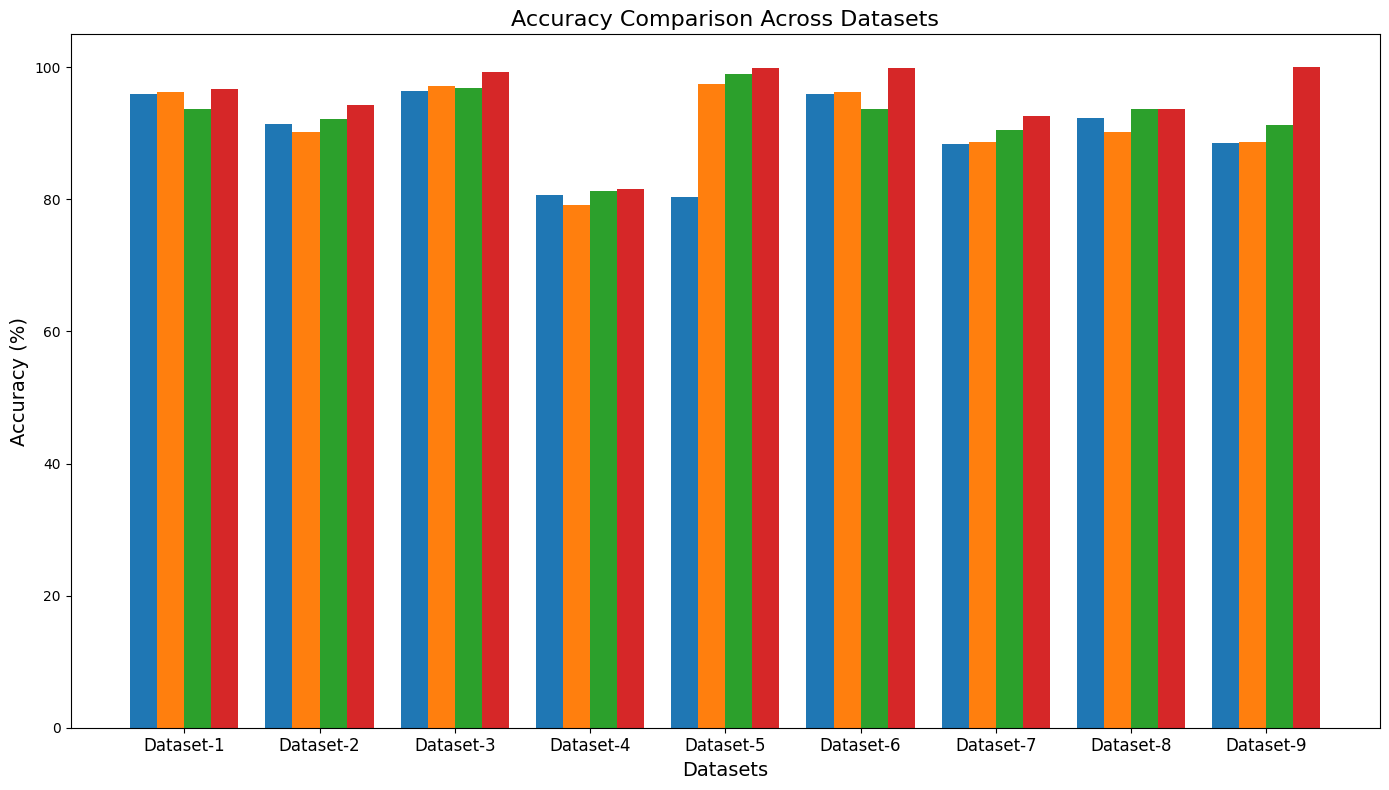

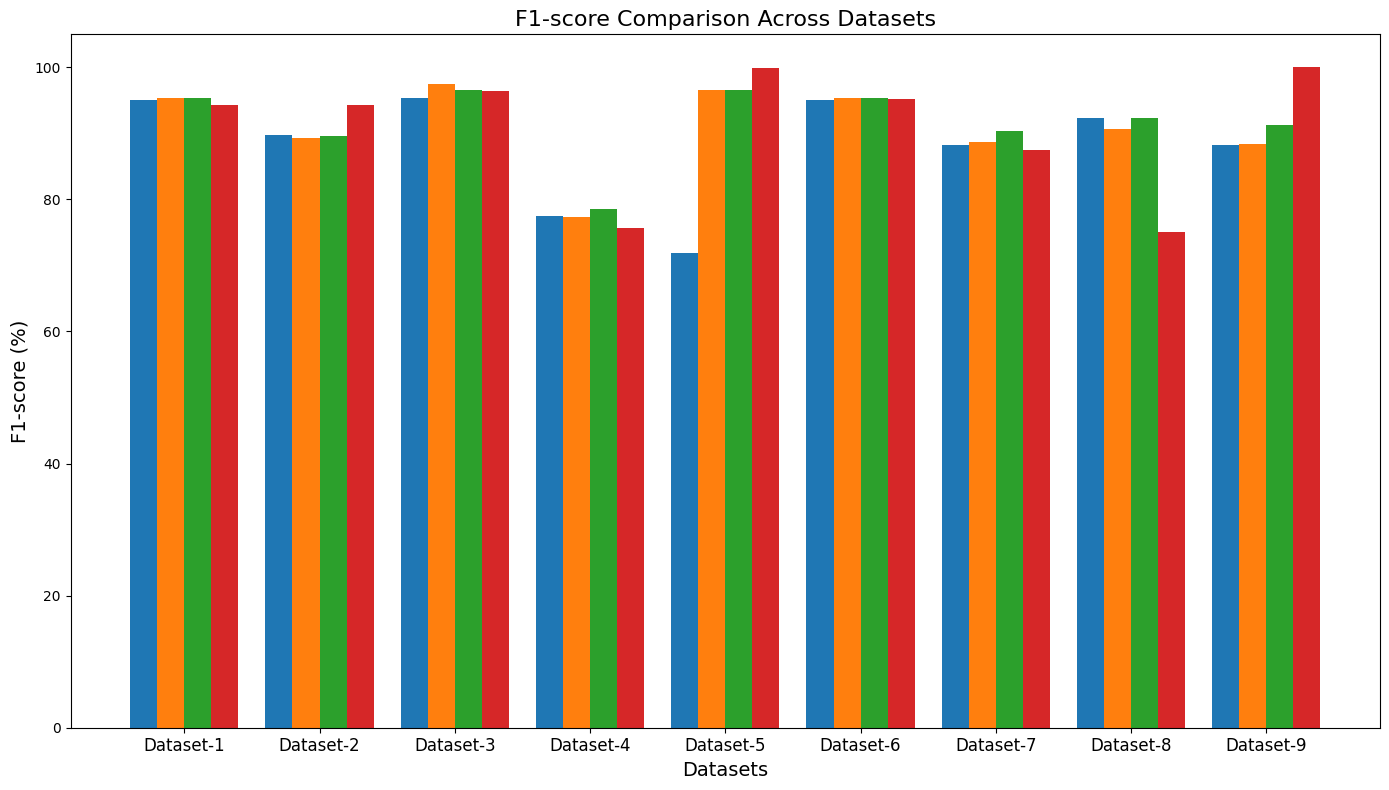

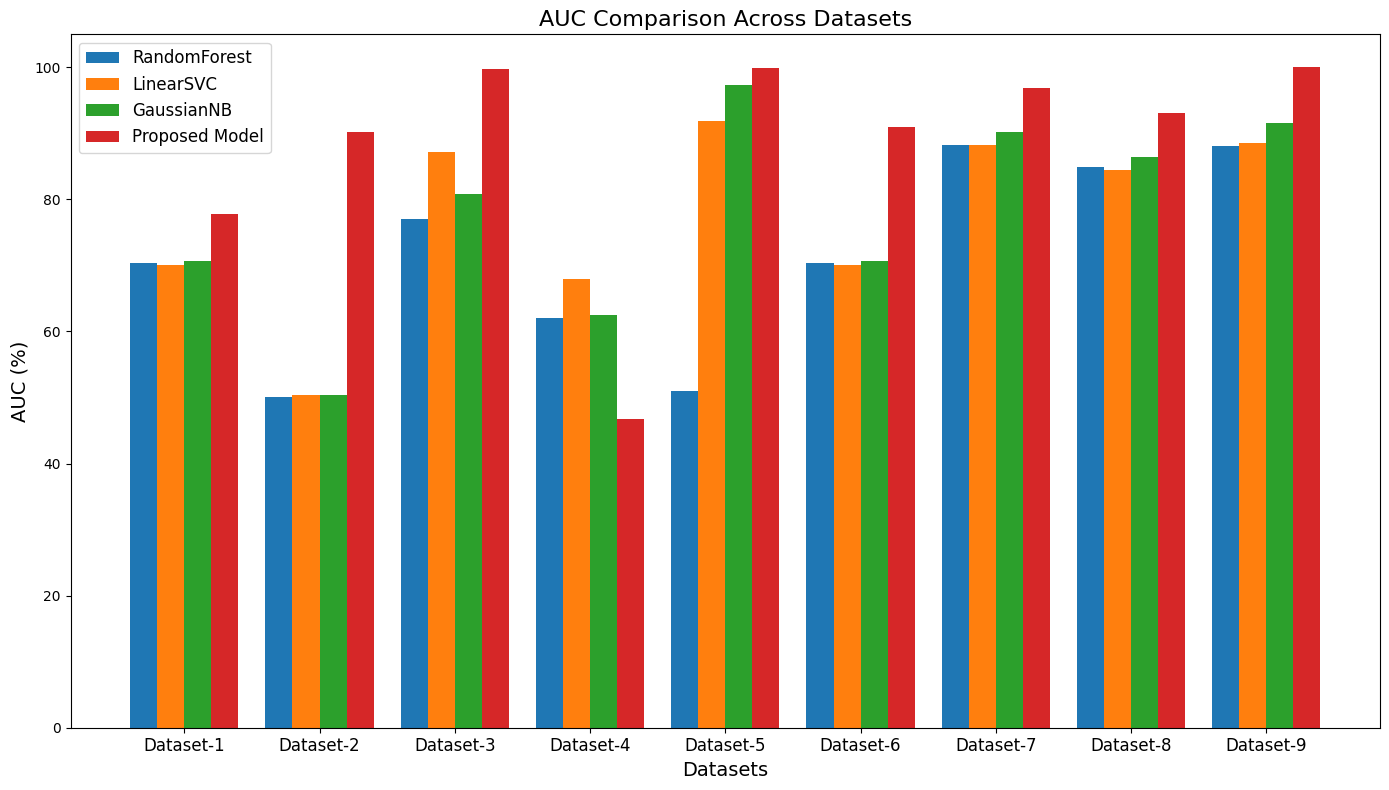

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Dataset names, model names, accuracy, f1-score, and AUC
datasets = ['Dataset-1', 'Dataset-2', 'Dataset-3', 'Dataset-4', 'Dataset-5', 'Dataset-6', 'Dataset-7', 'Dataset-8', 'Dataset-9']
models = ['RandomForest', 'LinearSVC', 'GaussianNB', 'Proposed Model']

# Accuracy, F1-score, and AUC for each model per dataset
accuracy = np.array([
    [96.03, 96.32, 93.71, 96.72],
    [91.43, 90.23, 92.14, 94.33],
    [96.46, 97.22, 96.82, 99.37],
    [80.73, 79.22, 81.28, 81.65],
    [80.32, 97.46, 99.03, 99.96],
    [96.03, 96.32, 93.71, 99.94],
    [88.36, 88.68, 90.49, 92.65],
    [92.35, 90.26, 93.63, 93.63],
    [88.48, 88.72, 91.29, 100.00]
])

f1_score = np.array([
    [95.12, 95.31, 95.31, 94.37],
    [89.76, 89.25, 89.62, 94.32],
    [95.42, 97.51, 96.62, 96.44],
    [77.42, 77.35, 78.57, 75.64],
    [71.87, 96.63, 96.59, 99.87],
    [95.12, 95.31, 95.31, 95.23],
    [88.27, 88.73, 90.37, 87.43],
    [92.27, 90.63, 92.37, 75.14],
    [88.23, 88.39, 91.34, 100.00]
])

auc = np.array([
    [70.35, 70.11, 70.64, 77.84],
    [50.12, 50.33, 50.36, 90.18],
    [77.09, 87.23, 80.75, 99.79],
    [62.09, 67.93, 62.48, 46.73],
    [50.99, 91.89, 97.26, 99.94],
    [70.35, 70.11, 70.64, 90.90],
    [88.19, 88.26, 90.28, 96.80],
    [84.84, 84.47, 86.48, 93.11],
    [88.07, 88.52, 91.58, 100.00]
])

# Bar width and positions for grouped bars
bar_width = 0.2
indices = np.arange(len(datasets))
bar_positions = [indices + bar_width * i for i in range(len(models))]

# Function to create bar plots for each metric
def plot_metric(metric_data, metric_name, show_legend=True):
    plt.figure(figsize=(14, 8))
    for i in range(len(models)):
        plt.bar(bar_positions[i], metric_data[:, i], bar_width, label=models[i])
    plt.xlabel('Datasets', fontsize=14)
    plt.ylabel(f'{metric_name} (%)', fontsize=14)
    plt.title(f'{metric_name} Comparison Across Datasets', fontsize=16)
    plt.xticks(indices + bar_width * (len(models) - 1) / 2, datasets, fontsize=12)
    if show_legend:
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plotting each metric separately
plot_metric(accuracy, 'Accuracy', show_legend=False)
plot_metric(f1_score, 'F1-score', show_legend=False)
plot_metric(auc, 'AUC', show_legend=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

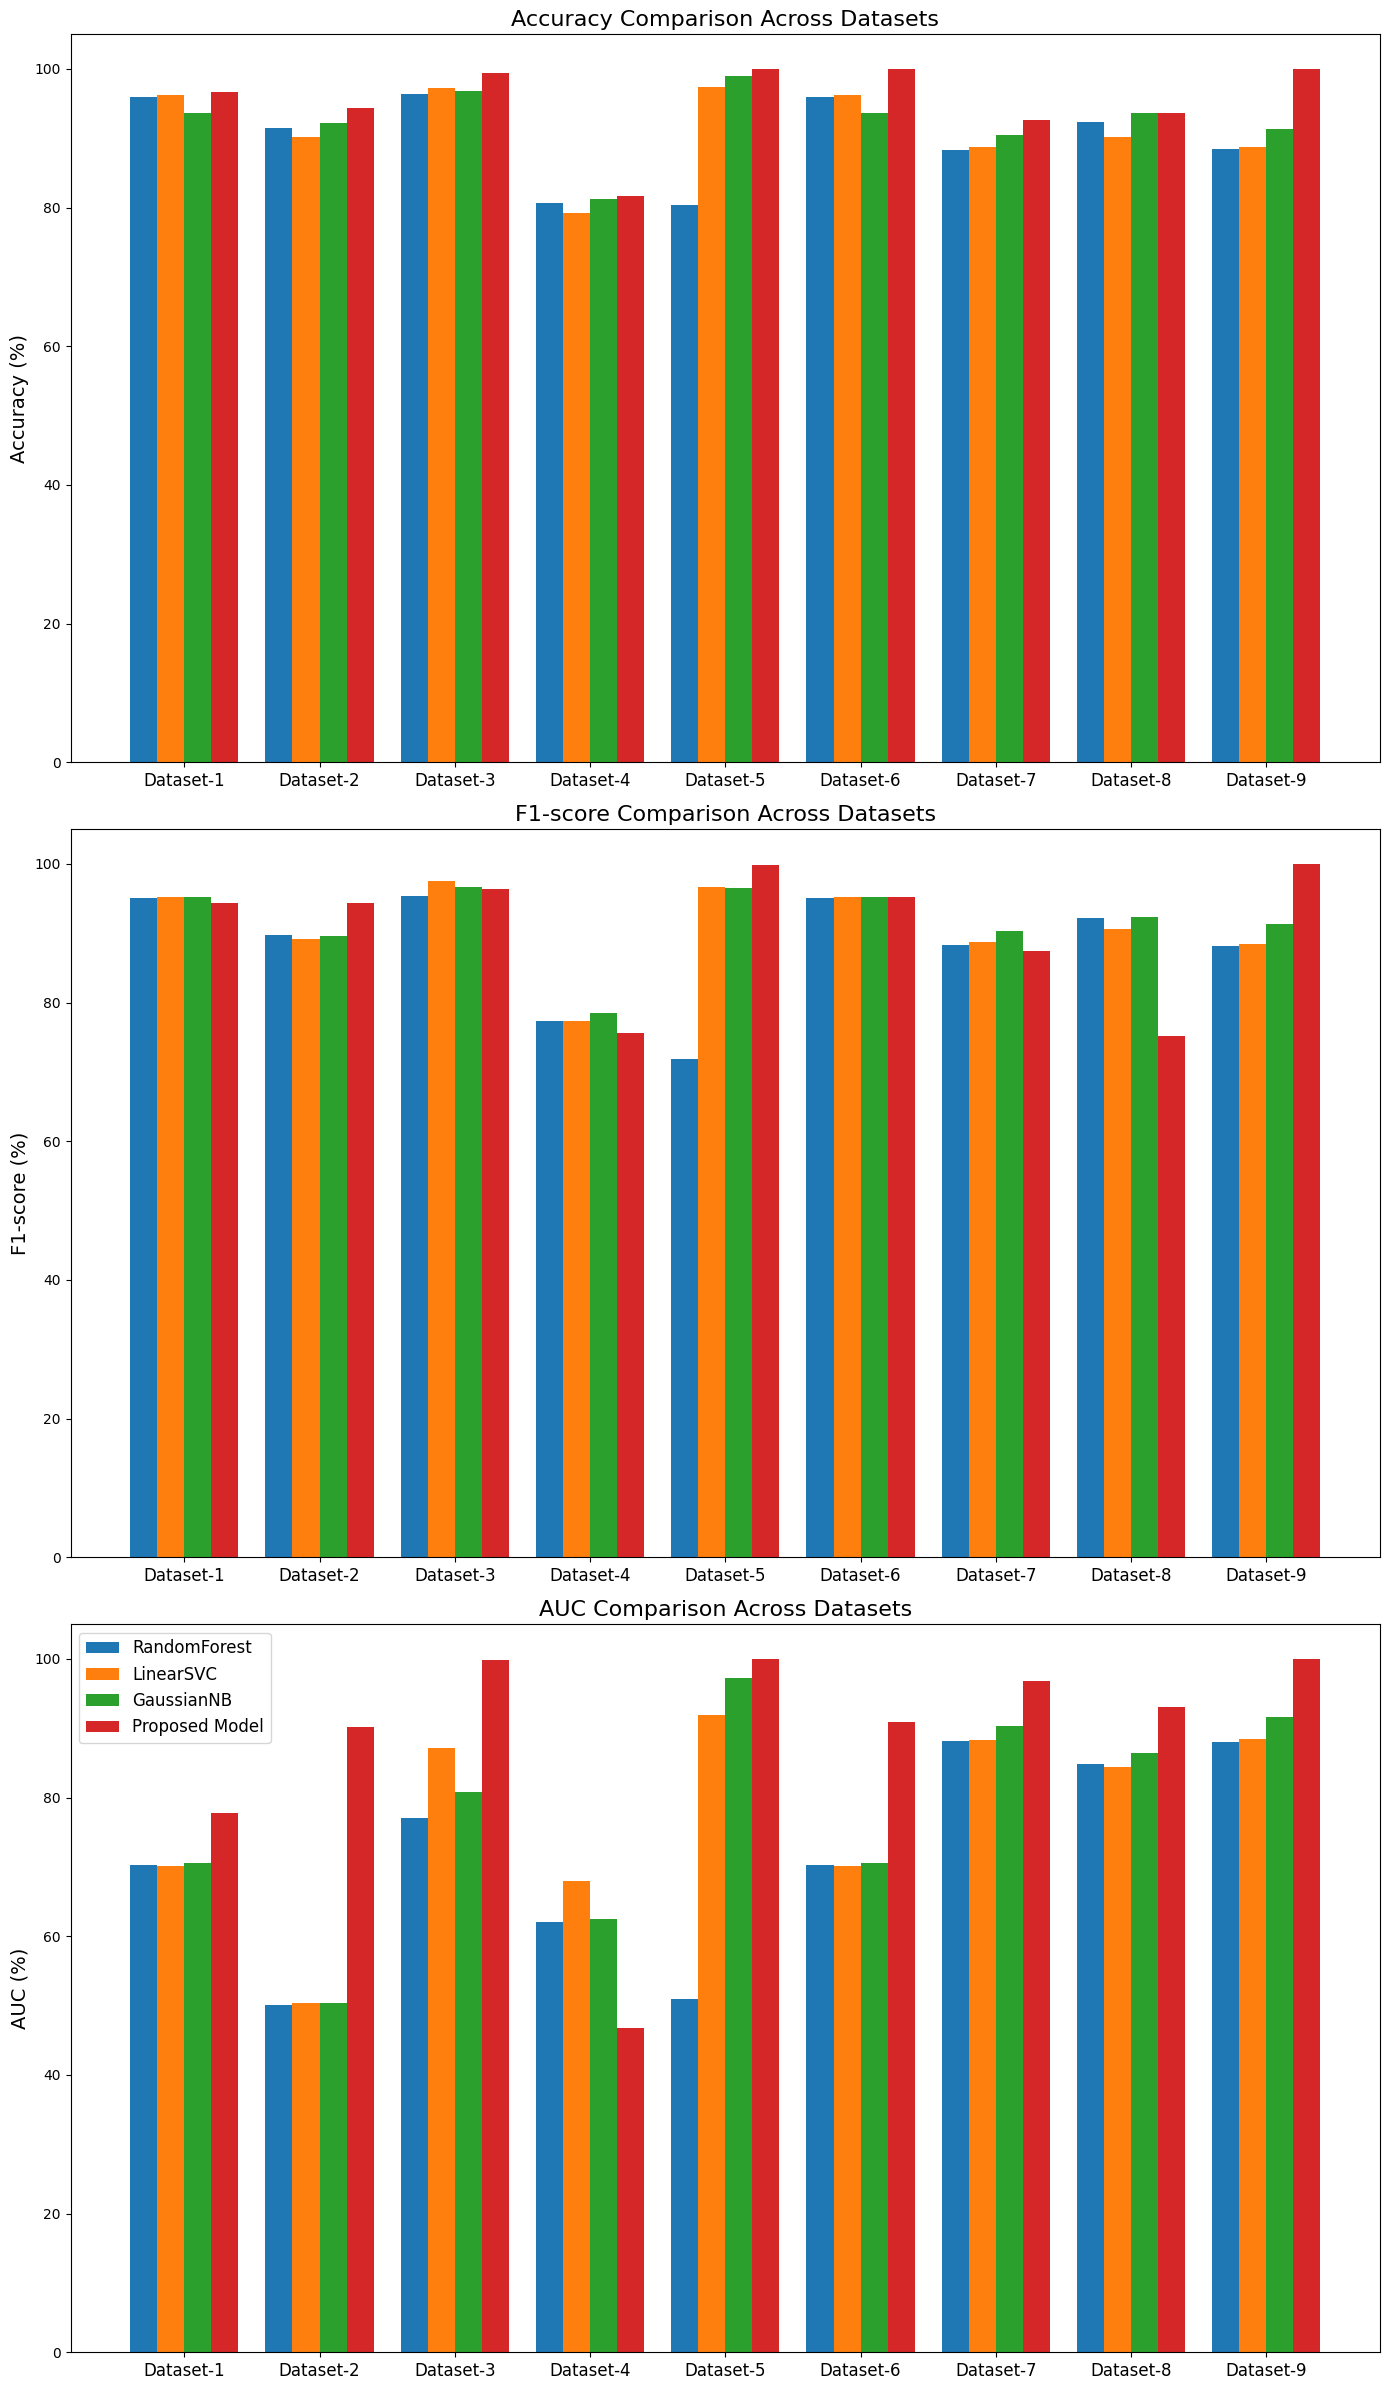

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Dataset names, model names, accuracy, f1-score, and AUC
datasets = ['Dataset-1', 'Dataset-2', 'Dataset-3', 'Dataset-4', 'Dataset-5', 'Dataset-6', 'Dataset-7', 'Dataset-8', 'Dataset-9']
models = ['RandomForest', 'LinearSVC', 'GaussianNB', 'Proposed Model']

# Accuracy, F1-score, and AUC for each model per dataset
accuracy = np.array([
    [96.03, 96.32, 93.71, 96.72],
    [91.43, 90.23, 92.14, 94.33],
    [96.46, 97.22, 96.82, 99.37],
    [80.73, 79.22, 81.28, 81.65],
    [80.32, 97.46, 99.03, 99.96],
    [96.03, 96.32, 93.71, 99.94],
    [88.36, 88.68, 90.49, 92.65],
    [92.35, 90.26, 93.63, 93.63],
    [88.48, 88.72, 91.29, 100.00]
])

f1_score = np.array([
    [95.12, 95.31, 95.31, 94.37],
    [89.76, 89.25, 89.62, 94.32],
    [95.42, 97.51, 96.62, 96.44],
    [77.42, 77.35, 78.57, 75.64],
    [71.87, 96.63, 96.59, 99.87],
    [95.12, 95.31, 95.31, 95.23],
    [88.27, 88.73, 90.37, 87.43],
    [92.27, 90.63, 92.37, 75.14],
    [88.23, 88.39, 91.34, 100.00]
])

auc = np.array([
    [70.35, 70.11, 70.64, 77.84],
    [50.12, 50.33, 50.36, 90.18],
    [77.09, 87.23, 80.75, 99.79],
    [62.09, 67.93, 62.48, 46.73],
    [50.99, 91.89, 97.26, 99.94],
    [70.35, 70.11, 70.64, 90.90],
    [88.19, 88.26, 90.28, 96.80],
    [84.84, 84.47, 86.48, 93.11],
    [88.07, 88.52, 91.58, 100.00]
])

# Bar width and positions for grouped bars
bar_width = 0.2
indices = np.arange(len(datasets))
bar_positions = [indices + bar_width * i for i in range(len(models))]

# Create a figure for subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 24))

# Plotting Accuracy
axs[0].set_title('Accuracy Comparison Across Datasets', fontsize=16)
for i in range(len(models)):
    axs[0].bar(bar_positions[i], accuracy[:, i], bar_width, label=models[i])
axs[0].set_ylabel('Accuracy (%)', fontsize=14)
axs[0].set_xticks(indices + bar_width * (len(models) - 1) / 2)
axs[0].set_xticklabels(datasets, fontsize=12)
# Removing the legend
axs[0].legend().remove()

# Plotting F1-score
axs[1].set_title('F1-score Comparison Across Datasets', fontsize=16)
for i in range(len(models)):
    axs[1].bar(bar_positions[i], f1_score[:, i], bar_width, label=models[i])
axs[1].set_ylabel('F1-score (%)', fontsize=14)
axs[1].set_xticks(indices + bar_width * (len(models) - 1) / 2)
axs[1].set_xticklabels(datasets, fontsize=12)
# Removing the legend
axs[1].legend().remove()

# Plotting AUC
axs[2].set_title('AUC Comparison Across Datasets', fontsize=16)
for i in range(len(models)):
    axs[2].bar(bar_positions[i], auc[:, i], bar_width, label=models[i])
axs[2].set_ylabel('AUC (%)', fontsize=14)
axs[2].set_xticks(indices + bar_width * (len(models) - 1) / 2)
axs[2].set_xticklabels(datasets, fontsize=12)
axs[2].legend(fontsize=12)

plt.tight_layout()

# Save the figure as an image file
image_path = '/content/metrics_comparison.png'
plt.savefig(image_path)

# Download the image
from google.colab import files
files.download(image_path)
